Original Author : @AustinRochford 
A Dockerfile that will produce a container with all the dependencies necessary to run this notebook is available [here](https://github.com/AustinRochford/notebooks).

In [1]:
%matplotlib inline

In [2]:
from warnings import filterwarnings

In [3]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from statsmodels.datasets import get_rdataset

In [4]:
import theano
import theano.tensor as t
import pymc3 as pm
from pymc3.model_graph import ModelGraph, model_to_graphviz

import matplotlib.image as mpimg

from scipy import stats

from utils import kde_scatter, summary

In [5]:
# configure pyplot for readability when rendered as a slideshow and projected
plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

In [6]:
filterwarnings('ignore', 'findfont')
filterwarnings('ignore', 'FutureWarning')

In [7]:
blue, green, red, purple, gold, teal = sns.color_palette(n_colors=6)

pct_formatter = StrMethodFormatter('{x:.1%}')

In [8]:
SEED = 54902 # from random.org, for reproducibility

np.random.seed(SEED)

# Introduction à l'Inférence Bayesienne avec Python et PyMC3
Club de lecture Octobre 2018
##### Alexis Fortin-Côté

<center><img src='https://ichef.bbci.co.uk/images/ic/896x504/p04pxlg4.jpg' width="90%"></center>

### How often have I said to you that when you have eliminated the impossible, whatever remains, however improbable, must be the truth?
##### -Sherlock Holmes, The Sign of the Four Chap. 6, p. 111,  (1890)

## A partir d'une présentation de [@AustinRochford](https://twitter.com/AustinRochford)
[original notebook](https://gist.github.com/AustinRochford/d83ecc6acd17a632a2b9df788386540b)

# Inférence Bayésienne et Analyses fréquentistes

<table align="center">
    <centering>
    <tr>
        <td>
            <span><img src="http://austinrochford.com/resources/talks/img/probabilistic_programming.png" width="500"></span>
        </td>
        <td>
            <span><img src="fig1_1.jpg" width="500"></span>
        </td>
    </tr>
    <tr>
        <td>
            Bayésienne
        </td>
        <td>
            Fréquentistes
        </td>
    </tr>
        </centering>
</table>

# Problème avec les p-values

- **Gelman, A., & Geurts, H. M. (2017). The statistical crisis in science: How is it relevant to clinical neuropsychology?. The Clinical Neuropsychologist, 31(6-7), 1000-1014.**  
- Baker, M. (2016). 1,500 scientists lift the lid on reproducibility. Nature News, 533(7604), 452.  
- Gelman, A. (2016). The problems with p-values are not just with p-values. The American Statistician, 70.  
- Button, K. S., Ioannidis, J. P., Mokrysz, C., Nosek, B. A., Flint, J., Robinson, E. S., & Munafò, M. R. (2013). Power failure: why small sample size undermines the reliability of neuroscience. Nature - Reviews Neuroscience, 14(5), 365.  
- Simmons, J., Nelson, L., & Simonsohn, U. (2011). False-positive psychology: Undisclosed fexibility in data collection and analysis allow presenting anything as signifcant. Psychological Science, 22, 1359–1366.  
- Schatz, P., Jay, K. A., McComb, J., & McLaughlin, J. R. (2005). Misuse of statistical tests in archives of clinical neuropsychology publications. Archives of Clinical Neuropsychology, 20, 1053–1059  
- Gelman, A. (2005). Analysis of variance—why it is more important than ever. The annals of statistics, 33(1), 1-53.  
- Bezeau, S., & Graves, R. (2001). Statistical power and effect sizes of clinical neuropsychology research. Journal of Clinical and Experimental Neuropsychology, 23(3), 399-406.  
- Meehl, P. E. (1990). Why summaries of research on psychological theories are often uninterpretable. Psychological Reports, 66, 195–244  

## Inférence Bayesienne

Exemple classique:


> Supposons un test sanguin permettant de détecter le vampirimse avec un taux de succès de 95%
Pr(positive|vampire) = 0.95. C'est donc un test précis, mais qui implique son lot de faux-positif. Un pourcent du temps le test sera positif pour une personne normale, donc Pr(positive|mortel)=0.01. La dernière donnée connue est qu'une personne sur mille est un vampire dans la population générale, donc Pr(vampire)=0.001

Probabilité d'être un vampire si on test positif? 95%? 1%?

### Probabilité conditionnelle

En théorie des probabilités, une [_probabilité conditionnelle_](https://fr.wikipedia.org/wiki/Probabilit%C3%A9_conditionnelle) est la probabilité d'un événement sachant qu'un autre événement a eu lieu.

$$
\begin{align*}
P(A\ |\ B)
    & = \textrm{La probabilité que } A \textrm{ arrive si on sait que } B \textrm{ est arrivé} \\
    & = \frac{P(A \textrm{ et } B)}{P(B)}.
\end{align*}
$$

Notre question,

Quelle est la probabilité qu'une personne soit un vampire si elle est testée positive?

$$
\begin{align*}
    P(vampire)
        & = 0.001 \\
    P(\textrm{Test } +\ |\ vampire)
        & = 0.95 \\
    P(\textrm{Test } +\ |\ mortel)
        & = 0.01 \\
    \\
    P(vampire\ |\ \textrm{Test } +)
        & =\ \textbf{?}
\end{align*}
$$

### Théorem de Bayes

[Le théorem de Bayes](https://en.wikipedia.org/wiki/Bayes%27_theorem) nous montre comment passer de $P(B\ |\ A)$ à $P(A\ |\ B)$.

<img src='https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif' width=300> $$\large P(A\ |\ B) = \frac{P(B\ |\ A)\ P(A)}{P(B)}$$

Le terme P(A) est la <font color="orange">probabilité a priori de A</font>. Elle est « antérieure » au sens qu’elle précède toute information sur B. Le terme P(A|B) est appelée la <font color="red">probabilité conditionnelle de A sachant B </font>. Elle est « postérieure », au sens qu’elle dépend directement de B. Le terme P(B|A), pour un B connu, est appelé <font color="blue"> la fonction de vraisemblance </font> de A. De même, le terme P(B) est appelé <font color="green">la probabilité marginale </font> ou a priori de B.

$$\color{red}{P(A\ |\ B)} = \frac{\color{blue}{P(B\ |\ A)}\ \color{orange}{P(A)}}{\color{green}{P(B)}}.$$

Pour plusieurs modèles la <font color="green">la probabilité marginale </font> **est impossible ou difficilement calculable analytiquement**.

Pour le cas qui nous intéresse, on peut calculer analytiquement la probabilité avec le théorème de Bayes et la [Formule des probabilités totales](https://fr.wikipedia.org/wiki/Formule_des_probabilit%C3%A9s_totales)

$$Pr(vampire|+)=\frac{Pr(+|vampire)Pr(vampire)}{Pr(+)}$$

$$
Pr(+)=Pr(+|vampire)Pr(vampire)+Pr(+|mortel)(1−Pr(vampire))
$$

$$
\begin{align*}
    P(vampire)
        & = 0.001 \\
    P(+\ |\ vampire)
        & = 0.95 \\
    P(+\ |\ mortel)
        & = 0.01 \\
    \\
    P(vampire\ |\ \textrm{Test } +)
        & = \frac{0.95*0.001}{0.95*0.001 + 0.01*(1-0.001)}
\end{align*}
$$

On observe qu'une personne qui reçoit un test positif a moins de 10% de chance d'être un vampire!

In [1]:
(0.95*0.001)/(0.95*0.001 + 0.01 * (1-0.001))

0.08683729433272395

### C'est un exemple classique, mais en soi pas particuilièrement Bayésien

Il existe une façon plus intuitive de poser problème

1.  Dans une population de 100,000 personnes, 100 sont vampires.

2.  De ces 100 vampires, 95 vont tester positif au test.

3.  Des 99,900 mortels, 999 vont tester positif au test.

Donc si on teste les 100,000 personnes, quelle est la proportion de ceux qui teste positif d'être des vampires? La question posée ainsi semble plus facile à répondre.

On a juste à compter le nombre de test positifs: 95 + 999 = 1094. On sait que dans le lot 95 sont des vampires:

Pr(vampire|+)=95/1094≈0.087

## Programmation probabilistique pour inférence bayesienne

<center><img src="http://austinrochford.com/resources/talks/img/probabilistic_programming.png"></center>

L'exemple précédant était déjà complexe à exprimer et pouvait se résoudre analytiquement parce qu'il était très simple.

## Résolvons le même problème avec Python

On connait la prévalence de la maladie dans la population générale, soit 1/1000

La distribution de [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution) donne la probabilité binaire (pile ou face biaisé).  Si $X \sim \textrm{Bernoulli}(p),$

$$
\begin{align*}
P(X = 1)
    & = p \\
P(X = 0)
    & = 1 - p.
\end{align*}
$$

In [10]:
import pymc3 as pm

with pm.Model() as disease_model:
    has_disease = pm.Bernoulli('est_vampire', 0.001)

Si la personne est vampire, il y a 95% de chance de tester positif. Sinon, il y a quand même  1% de chance de tester positif

In [11]:
with disease_model:
    p_test_pos = has_disease * 0.95 + (1 - has_disease) * 0.01

La personne dans l'exemple a testé positive alors:

In [12]:
with disease_model:
    test_pos = pm.Bernoulli('test_pos', p_test_pos, observed=1)

Quelle est la probabilité que cette personne ait la maladie

In [13]:
with disease_model:
    disease_trace = pm.sample(draws=10000, random_seed=SEED, cores=1)

Sequential sampling (2 chains in 1 job)
BinaryGibbsMetropolis: [est_vampire]
100%|██████████████████████████████████| 10500/10500 [00:01<00:00, 7420.49it/s]
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


On obtient un échantillionnage de la distribution postérieur, sachant que nous avons observé un test positif

In [14]:
disease_trace['est_vampire']

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

La moyenne des échantillions `has_disease` provenant de la distribution postierieure est la probabilité que cette personne ait la maladie, sachant qu'elle a testé positif

In [15]:
disease_trace['est_vampire'].mean()

0.0862

Ce qu'on a calculé tantôt:

In [16]:
(0.95*0.001)/(0.95*0.001 + 0.01 * (1-0.001))

0.08683729433272395

### Méthodes de Monte Carlo

[Les méthodes de Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) utilisent un échantillionnage aléatoire pour aproximer des quantités difficile a obtenir analytiquement. Ils sont un outil essentiel pour l'inférence Bayesienne où la distribution marginale est habituellement difficile à obtenir.

#### Un exemple
On génère 5000 points distribués aléatoirement dans un carré unitaire

In [89]:
N = 50000

x, y = np.random.uniform(0, 1, size=(2, N))

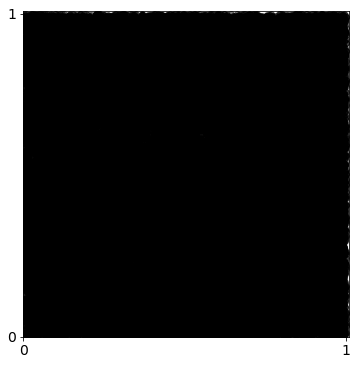

In [90]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

ax.scatter(x, y, c='k', alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

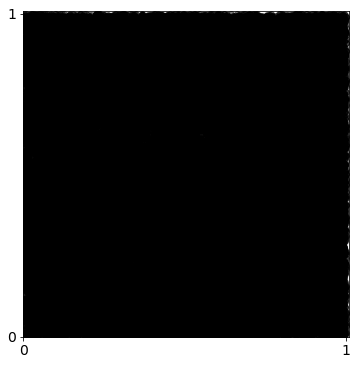

In [91]:
fig

En comptant le nombre de point qui tombent dans le quatier de cercle de rayon 1, on obtient une approximation de l'aire dans de quartier de cercle, qui est en réalité de $\frac{\pi}{4}$.

In [92]:
in_circle = x**2 + y**2 <= 1

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


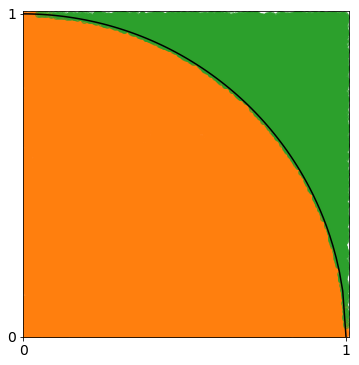

In [93]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, np.sqrt(1 - x_plot**2), c='k');

ax.scatter(x[in_circle], y[in_circle], c=green, alpha=0.5);
ax.scatter(x[~in_circle], y[~in_circle], c=red, alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

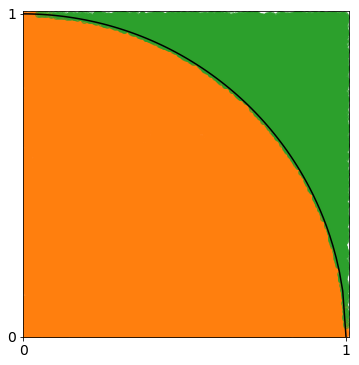

In [94]:
fig

Comme on s'y attend, 4 fois l'approximation du quart de l'air donne près de $\pi$. Plus d'échantillions donnerais une meilleur approximation

In [95]:
4 * in_circle.mean()

3.14448

#### Historique des méthodes de Monte Carlo

<center><img src="http://www.bgu.ac.il/~oaharon/feynman/Feynman_Portraits_files/Ulam_Feynman_von_Neumann.jpg"></center>

Les méthodes de Monte Carlo ont été largement utilisées pour le [Projet Manhattan](https://en.wikipedia.org/wiki/Monte_Carlo_method#Definitions).  Sur la photo ci-dessus, on voit des scientifiques du projet Manhattan [Stanislaw_Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam),[Richard Feynman](https://en.wikipedia.org/wiki/Richard_Feynman) et [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann). En travaillant sur le projet Manhattan, Ulam a donné l'une des premières descriptions des algorithmes des [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Monte_Carlo). La librairie de programmation probabiliste [Stan](http://mc-stan.org/) est nommé en son honneur.

# Étude de cas: 
## La pièce de monnaie truquée
>Nous avons en notre possession une pièce de monnaie. On veut savoir si elle est truquée, c.-à-d. si la probabilité d'obtenir pile ou face est égale

### Bayésien = Mise à jour de nos apriori en fonction de nos observations

On peut représenter un lancer de la pièce par un essai de Bernouilli, qui prend la valeur 1 avec la probabilité p.

À priori on ne connait pas la valeur de p. Donc la plausibilité de p est uniforme entre 0 et 1.

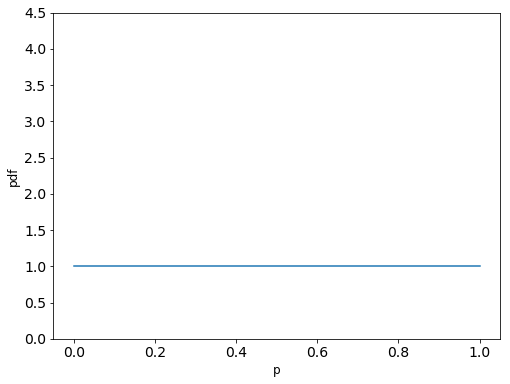

In [10]:
x = np.linspace(0, 1, 200)
pdf = stats.beta.pdf(x, 1, 1)
plt.plot(x, pdf)
plt.xlabel('p', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.ylim(0, 4.5)
plt.show()

On lance la pièce de monnaie, on obtient face

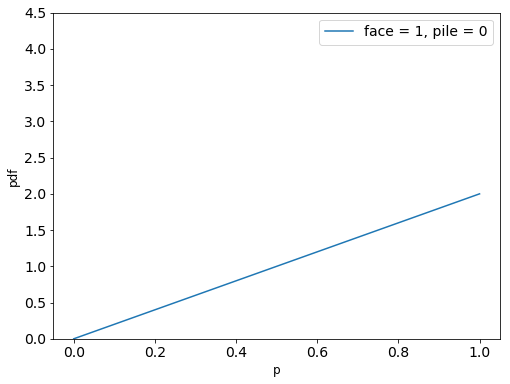

In [13]:
x = np.linspace(0, 1, 200)
pdf = stats.beta.pdf(x, 2, 1)
plt.plot(x, pdf, label=r'face = {}, pile = {}'.format(1, 0))
plt.legend()
plt.xlabel('p', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.ylim(0, 4.5)
plt.show()

On lance la pièce de monnaie, on obtient pile

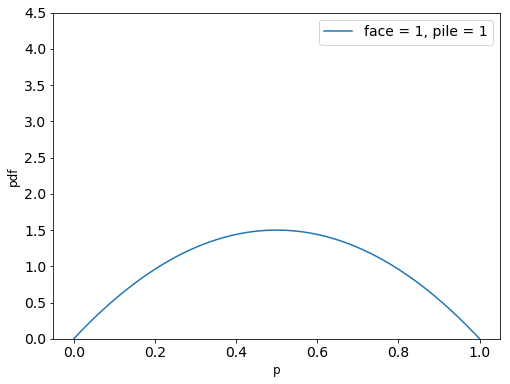

In [14]:
x = np.linspace(0, 1, 200)
pdf = stats.beta.pdf(x, 2, 2)
plt.plot(x, pdf, label=r'face = {}, pile = {}'.format(1, 1))
plt.legend()
plt.xlabel('p', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.ylim(0, 4.5)
plt.show()

On lance la pièce de monnaie, on obtient pile

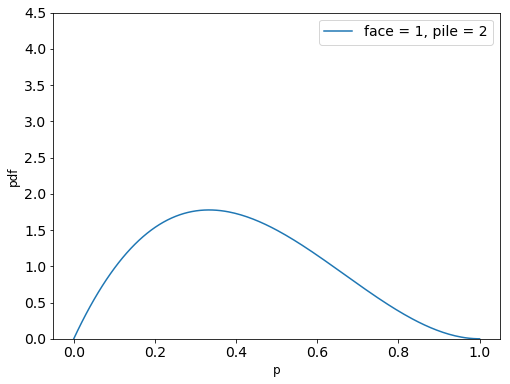

In [15]:
x = np.linspace(0, 1, 200)
pdf = stats.beta.pdf(x, 2, 3)
plt.plot(x, pdf, label=r'face = {}, pile = {}'.format(1, 2))
plt.legend()
plt.xlabel('p', fontsize=12)
plt.ylabel('pdf', fontsize=12)
plt.ylim(0, 4.5)
plt.show()

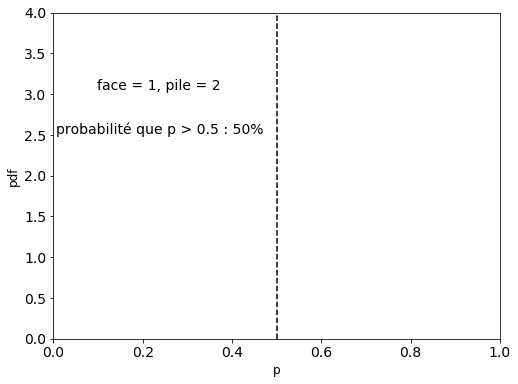

In [82]:
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 1))
ax.set_ylim((0, 4))

x = np.linspace(0, 1, 200)
pdf = stats.beta.pdf(x, 2, 3)
line = ax.plot(x, pdf)[0]
ax.vlines(0.5, 0, 999, linestyles='--')
texts = fig.text(0.2,0.7,'face = {}, pile = {}'.format(1, 2), fontsize=14)
texts2 = fig.text(0.13,0.6,'probabilité que p > 0.5 : {:.0%}'.format(0.5), fontsize=14)
plt.xlabel('p', fontsize=12)
plt.ylabel('pdf', fontsize=12)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
rv = stats.bernoulli(0.6)
pile = 0
face = 0
def animate(i):
    global pile, face
    sample = rv.rvs(1)[0]
    face+= sample
    pile+= 1-sample
    pdf = stats.beta.pdf(x, 1+face, 1+pile)
    cdf = stats.beta.cdf(0.5, 1+face, 1+pile)
    line.set_data(x, pdf)
    texts.set_text(r'face = {}, pile = {}'.format(face, pile))
    texts2.set_text('probabilité que p > 0.5 : {:.0%}'.format(1-cdf))
    ax.set_ylim((0, np.max(pdf)))
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=50, interval=500, blit=True)

In [83]:
HTML(anim.to_html5_video())

# Étude de cas : Le problème de Monty Hall

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png' width="45%"></center>

Le [problème de Monty Hall](https://en.wikipedia.org/wiki/Monty_Hall_problem) est un célèbre puzzle de probabilité, basé sur l'émission de jeux des années 1960 [Let's Make a Deal](https://en.wikipedia.org/wiki/Let%27s_Make_a_Deal) et nommé d'après son hôte d'origine. Dans le jeu, un concurrent se voyait présenter trois portes, dont deux contenaient un article de peu ou pas de valeur (par exemple, une chèvre) et l'une d'entre elles contenait un article de très grande valeur (par exemple, une voiture de luxe). Le concurrent devait d'abord deviner quelle porte contenait la voiture de sport. Après la devinette initiale du concurrent, Monty ouvrait l'une des deux autres portes, révélant une chèvre. Monty offrait alors au concurrent la chance de changer leur choix de porte. Le problème de Monty Hall pose la question suivante : le candidat doit-il conserver son choix initial de porte ou le changer ?



Au départ, nous n'avons aucune information sur la porte derrière laquelle se trouve le prix.

In [24]:
with pm.Model() as monty_model:
    prize = pm.DiscreteUniform('prize', 0, 2)

Si nous choisisson la porte 1:

<table>
    <tr>
        <td></td>
        <th colspan="3"><center>Monty peut ouvrir</center></th>
    </tr>
    <tr>
        <th>Prix derrière</th>
        <td>Porte 1</td>
        <td>Porte 2</td>
        <td>Porte 3</td>
    </tr>
    <tr>
        <td>Porte 1</td>
        <td><font color="red">Non</font></td>
        <td><font color="green">Oui</font></td>
        <td><font color="green">Oui</font></td>
    </tr>
    <tr>
        <td>Porte 2</td>
        <td><font color="red">Non</font></td>
        <td><font color="red">Non</font></td>
        <td><font color="green">Oui</font></td>
    </tr>
    <tr>
        <td>Porte 3</td>
        <td><font color="red">Non</font></td>
        <td><font color="green">Oui</font></td>
        <td><font color="red">Non</font></td>
    </tr>
</table>

In [25]:
from theano import tensor as tt

with monty_model:
    # Probability that Monty open each door
    p_open = pm.Deterministic('p_open',
                              tt.switch(tt.eq(prize, 0),
                                        # it is behind the first door
                                        np.array([0., 0.5, 0.5]),
                              tt.switch(tt.eq(prize, 1),
                                        # it is behind the second door
                                        np.array([0., 0., 1.]),
                                        # it is behind the third door
                                        np.array([0., 1., 0.]))))

Monty ouvre la porte 3 contenant une chèvre

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png'></center>

In [26]:
with monty_model:
    opened = pm.Categorical('opened', p_open, observed=2)

Doit-on changer de porte?

In [27]:
with monty_model:
    monty_trace = pm.sample(draws=10000, random_seed=SEED)
    
monty_df = pm.trace_to_dataframe(monty_trace)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [prize]
Sampling 4 chains: 100%|████████████| 42000/42000 [00:18<00:00, 2259.64draws/s]
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 25% for some parameters.


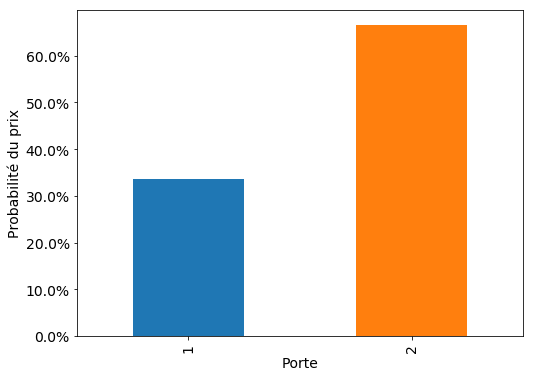

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = (monty_df.groupby('prize')
              .size()
              .div(monty_df.shape[0])
              .plot(kind='bar', ax=ax))

ax.set_xlabel("Porte");
ax.set_xticklabels([1, 2])
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Probabilité du prix");

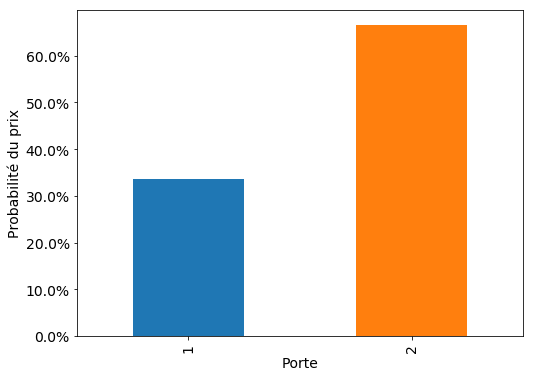

In [29]:
fig

Donc, oui on devrait changer de porte

**En option**

We can also resolve the Monty Hall problem with pen and paper, as follows.

Throughout this calculation, all probabilities assume that we have initially chosen the first door.  By Bayes' Theorem, the probability that the sportscar is behind door one given that Monty opened door three is

$$P(\textrm{Behind door one}\ |\ \textrm{Opened door three}) = \frac{P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one})}{P(\textrm{Opened door three})}.$$

The a priori probability that the prize is behind any of the doors is one third.  From the table above, $P(\textrm{Opened door three}\ |\ \textrm{Behind door one}) = \frac{1}{2}$.  We calculate $P(\textrm{Opened door three})$ using the law of total probability as follows:

$$
\begin{align*}
P(\textrm{Opened door three})
    & = P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one}) \\
    & + P(\textrm{Opened door three}\ |\ \textrm{Behind door two})P(\textrm{Behind door two}) \\
    & + P(\textrm{Opened door three}\ |\ \textrm{Behind door three})P(\textrm{Behind door three}) \\
    & = \frac{1}{2} \cdot \frac{1}{3} + 1 \cdot \frac{1}{3} + 0 \cdot \frac{1}{3} \\
    & = \frac{1}{2}.
\end{align*}
$$

Therefore

$$
\begin{align*}
P(\textrm{Behind door one}\ |\ \textrm{Opened door three})
    & = \frac{P(\textrm{Opened door three}\ |\ \textrm{Behind door one})P(\textrm{Behind door one})}{P(\textrm{Opened door three})} \\
    & = \frac{\frac{1}{2} \cdot \frac{1}{3}}{\frac{1}{3}} \\
    & = \frac{1}{3}.
\end{align*}$$

Since $P(\textrm{Behind door three}\ |\ \textrm{Opened door three}) = 0$, because Monty wants the contestant's choice to be suspensful, $P(\textrm{Behind door two}\ |\ \textrm{Opened door three}) = \frac{2}{3}$.  Therefore it is correct to switch doors, confirming our computational results.

# Étude de cas: Sleep Deprivation

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5c/%22Plenty_of_sleep_keeps_him_on_the_job%22_-_NARA_-_514792.jpg/1280px-%22Plenty_of_sleep_keeps_him_on_the_job%22_-_NARA_-_514792.jpg" width=300></center>

Les données proviennent de la librairie [`lme4`](https://cran.r-project.org/web/packages/lme4/) du language R, qui cite 

Gregory Belenky, Nancy J. Wesensten, David R. Thorne, Maria L. Thomas, Helen C. Sing, Daniel P. Redmond, Michael B. Russo and Thomas J. Balkin (2003) Patterns of performance degradation and restoration during sleep restriction and subsequent recovery: a sleep dose-response study. _Journal of Sleep Research_ 12, 1–12.

In [30]:
sleep_df = (get_rdataset('sleepstudy', 'lme4', cache=True)
                .data
                .rename(columns=str.lower)
                .assign(reaction_std=lambda df: (df.reaction - df.reaction.mean()) / df.reaction.std()))

In [31]:
sleep_df.head()

reaction  days  subject  reaction_std
0  249.5600     0      308     -0.868968
1  258.7047     1      308     -0.706623
2  250.8006     2      308     -0.846944
3  321.4398     3      308      0.407108
4  356.8519     4      308      1.035777

Dans cette étude, chacun des sujets obtient son temps normal de sommeil lors du premier jour.  Leur temps de sommeil est réduit à 3 heures pour les journées subséquentes.  La colonne`reaction` est leur temps de réponse moyen à un nombre de tests.  La colonne `reaction_std` est le résultat de la [standardisation](https://en.wikipedia.org/wiki/Standard_score) (Z-score) `reaction` sur tous les sujets et tous les jours.

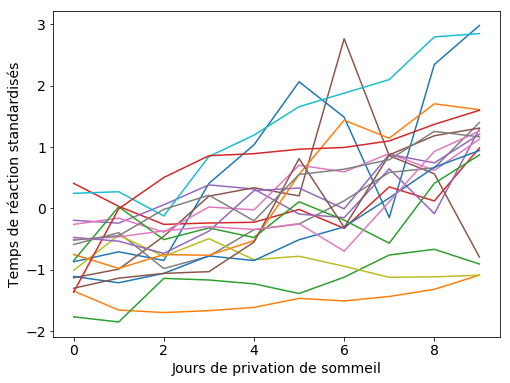

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

(sleep_df.groupby('subject')
         .plot('days', 'reaction_std',
               ax=ax, legend=False));

ax.set_xlabel("Jours de privation de sommeil");
ax.set_ylabel("Temps de réaction standardisés");

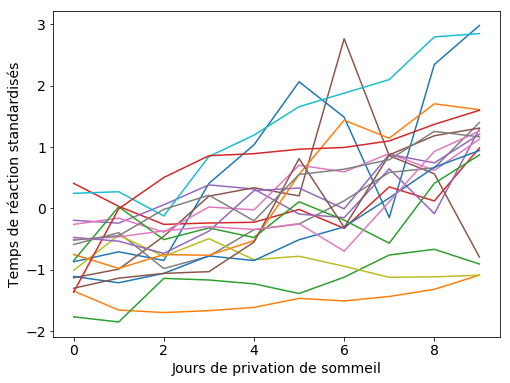

In [33]:
fig

We translate the subject ids in `sleep_df`, which start at 308, to begin at zero and increase sequentially.

In [34]:
subject_ix, subject_map = sleep_df.subject.factorize()
n_subjects = subject_map.size

days = sleep_df.days.values
reaction_std = sleep_df.reaction_std.values

Chaque sujet devrait avoir un temps de réaction de base qui ne devrait pas trop différer les uns des autres

In [35]:
with pm.Model() as sleep_model:
    μ_α = pm.Normal('μ_α', 0., 5.)
    σ_α = pm.HalfCauchy('σ_α', 5.)
    α = pm.Normal('α', μ_α, σ_α, shape=n_subjects)

Le taux de croissance des temps de réponse en fonction du nombre de jours de privation de sommeil différe selon chacun des sujets.

In [36]:
with sleep_model:
    μ_β = pm.Normal('μ_β', 0., 5.)
    σ_β = pm.HalfCauchy('σ_β', 5.)
    β = pm.Normal('β', μ_β, σ_β, shape=n_subjects)

La combinaison du temps de réponse de base et du taux de croissance correspondent à nos observations.

In [37]:
with sleep_model:
    μ = pm.Deterministic('μ', α[subject_ix] + β[subject_ix] * days)
    σ = pm.HalfCauchy('σ', 5.)
    obs = pm.Normal('obs', μ, σ, observed=reaction_std)

Ce type de model est connu sous le nom de model linéaire hiérarchique (mixe) "hierarchical (or mixed) linear model", parce que il permet à la pente et à la valeur initiale de variée selon le sujet, mais ajoute un terme de régularisation grâce à un apriori partagé par les sujets. Pour plus d'informations lire Gelman and Hill [_Data Analysis Using Regression and Multilevel/Hierarchical Models_](http://www.stat.columbia.edu/~gelman/arm/).

In [38]:
N_JOBS = 3
JOB_SEEDS = [SEED + i for i in range(N_JOBS)]

with sleep_model:
    sleep_trace = pm.sample(njobs=N_JOBS, random_seed=JOB_SEEDS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [σ, β, σ_β, μ_β, α, σ_α, μ_α]
Sampling 3 chains: 100%|███████████████| 3000/3000 [00:13<00:00, 227.95draws/s]
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


### Diagnostic de la convergence

PyMC3 met à disposition une suite d'outils de diagnostic de convergence [statistcal convergence diagnostics](http://pymc-devs.github.io/pymc3/api/stats.html) pour s'assurer que les échantillions soient une bonne approximation de la vrai distribution postérieure.

Les tracés d'énergie et la fraction bayésienne d'informations manquantes (BFMI) sont deux diagnostics pertinents pour l'échantillonnage Monte Carlo Hamiltonien, que nous avons utilisé dans cet exemple.  Si les deux distributions dans le tracé d'énergie diffèrent de façon significative (surtout dans les queues), l'échantillonnage n'a pas été très efficace.  La fraction bayésienne des informations manquantes quantifie cette différence avec un nombre compris entre zéro et un.  Un BFMI proche de 1 est préférable, et un BFMI inférieur à 0,2 indique des problèmes d'efficacité.

Pour plus d'information : Michael Betancourt [_A Conceptual Introduction to Hamiltonian Monte Carlo_](https://arxiv.org/abs/1701.02434) et [_Robust Statistical Workflow with PyStan_](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html).

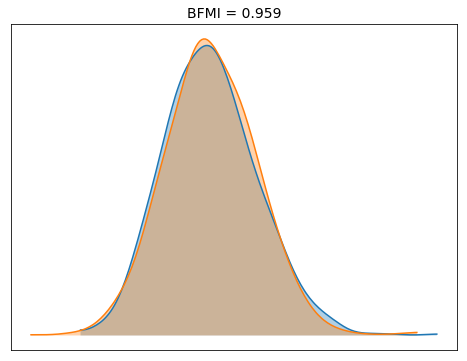

In [39]:
ax = pm.energyplot(sleep_trace, legend=False)
ax.set_title("BFMI = {:.3f}".format(pm.bfmi(sleep_trace)));

Contrairement aux tracés énergétiques et aux BFMI, qui sont spécifiques aux algorithmes de Monte Carlo Hamiltonien, la statistique [Gelman-Rubin](http://blog.stata.com/2016/05/26/gelman-rubin-convergence-diagnostic-using-multiple-chains/) est applicable à n'importe quel algorithme MCMC, à condition que plusieurs chaînes aient été échantillonnées.  Une statistique de Gelman-Rubin près de 1 est préférable, et les valeurs inférieures à 1,1 sont généralement considérées comme une indication de convergence.

In [40]:
max(np.max(gr_values) for gr_values in pm.gelman_rubin(sleep_trace).values())

1.0042896858571944

### Prediction

En inférence Bayesienne les prédictions sont effectuées en échantillionnant la [distribution postiérieur](https://en.wikipedia.org/wiki/Posterior_predictive_distribution), qui est la distribution des observations futures possibles sachant les observations antérieures.

In [41]:
with sleep_model:
    pp_sleep_trace = pm.sample_ppc(sleep_trace)

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 1326.26it/s]


We convert the posterior predictive samples to a `DataFrame`.

In [42]:
PP_DATA= {'pp_{}'.format(i):  pp_col for i, pp_col in enumerate(pp_sleep_trace['obs'])}
PP_COLS = list(PP_DATA.keys())

pp_df = sleep_df.assign(**PP_DATA)

In [43]:
pp_df.head()

reaction  days  subject  reaction_std      pp_0      pp_1      pp_2  \
0  249.5600     0      308     -0.868968 -0.890141  0.514229 -1.814552   
1  258.7047     1      308     -0.706623 -0.725305 -0.233810 -0.445534   
2  250.8006     2      308     -0.846944 -0.296069 -0.014863  0.204777   
3  321.4398     3      308      0.407108  0.412651 -0.444827 -0.145654   
4  356.8519     4      308      1.035777  0.594311  0.634889 -0.028154   

       pp_3      pp_4      pp_5    ...       pp_490    pp_491    pp_492  \
0 -0.418134 -0.797194 -0.459675    ...    -1.766223 -1.650690 -1.190322   
1 -0.191114  0.007865 -1.152587    ...    -1.001274 -0.505686 -0.054972   
2 -0.458021 -0.294116 -0.730840    ...    -0.834290 -0.482197  0.544785   
3 -0.476851  0.622550  0.807614    ...     0.405701 -0.136766  0.364942   
4 -0.046365  0.835659  0.409120    ...     0.531687  0.129832  0.884408   

     pp_493    pp_494    pp_495    pp_496    pp_497    pp_498    pp_499  
0 -1.697140 -0.994287 -0.444406 -0.749693 -0.158537  0.164312 -0.249929  
1 -0.831341 -0.160696 -0.148323  0.359490 -0.306998 -0.083120 -0.496599  
2 -0.101860  0.136675  0.654274  0.485466 -0.432618  0.295079 -0.636435  
3  0.469502 -0.292710  0.062846  0.470606  0.850621  0.085148  0.335992  
4  0.907722  0.276634  0.351549  1.066166  0.641605  0.340408 -0.356312  

[5 rows x 504 columns]

In [44]:
def pp_subject_plot(pp_subject_df, ax):
    low = pp_subject_df[PP_COLS].quantile(0.025, axis=1)
    high = pp_subject_df[PP_COLS].quantile(0.975, axis=1)

    ax.fill_between(pp_subject_df.days, low, high,
                    color='k', alpha=0.25)

    ax.plot(pp_subject_df.days, pp_subject_df.reaction_std)
    ax.plot(pp_subject_df.days, pp_subject_df[PP_COLS].mean(axis=1),
            c='k');
    
def pp_subject_plot_helper(data=None, **_):
    pp_subject_plot(data, plt.gca())

The following plot shows the predicted and observed reaction times for each subjects.

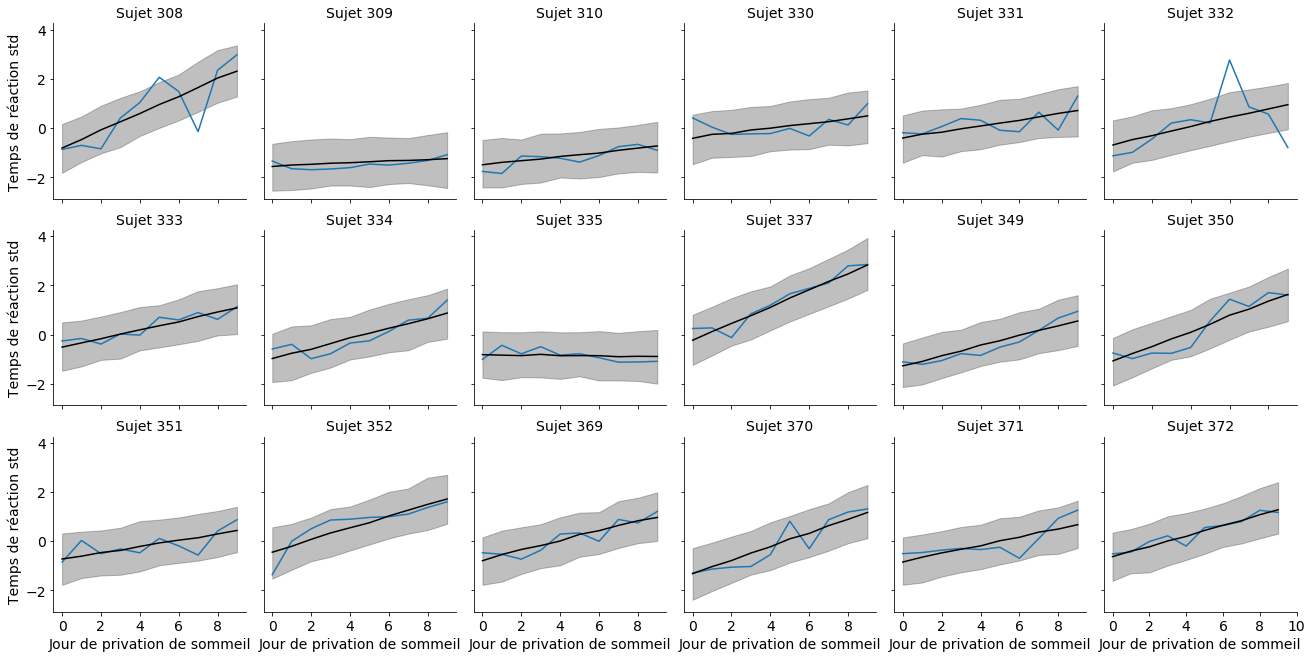

In [45]:
grid = sns.FacetGrid(pp_df, col='subject', col_wrap=n_subjects // 3)
grid.map_dataframe(pp_subject_plot_helper);

grid.set_axis_labels("Jour de privation de sommeil", "Temps de réaction std");
ax = plt.gca()
ax.set_xticks([0, 2, 4, 6, 8, 10])
grid.set_titles("Sujet {col_name}");

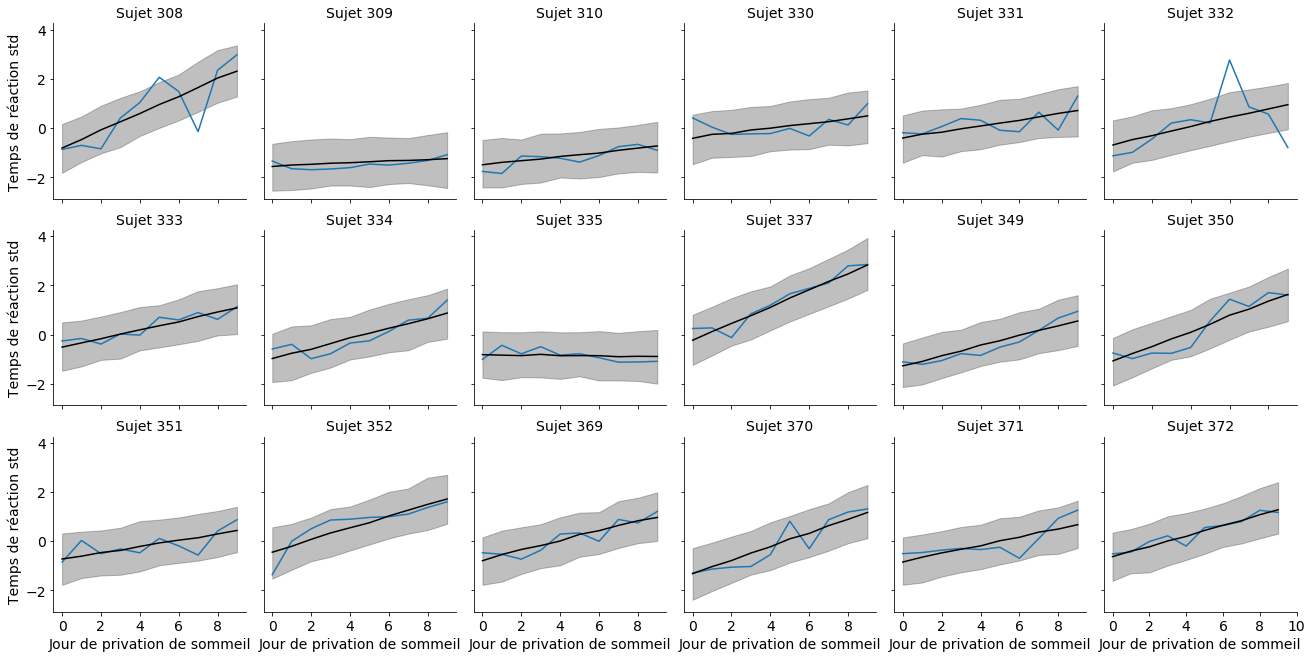

In [46]:
grid.fig

# Étude de cas: EEVEE

In [9]:
df = pd.read_pickle('eevee.pkl')
participants = np.sort(df.participant.unique())
num_participant = len(df.participant.unique())

avatars = np.sort(df.avatar.unique())
num_avatar = len(df.avatar.unique())

cores = 4
#myNormal = pm.Normal
def myNormal(*args, **kwargs): 
    return pm.TruncatedNormal(*args, **kwargs, upper=100, lower=0)

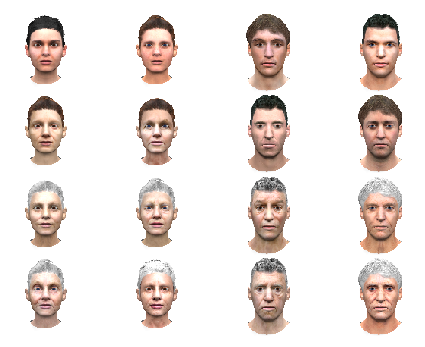

In [10]:
fig = plt.figure()
for idx, avatar in enumerate(avatars[:]):
    plt.rcParams["axes.edgecolor"] = "white"
    plt.subplot(4, 4, idx+1)
    plt.subplots_adjust(wspace=0, hspace=0)
    img=mpimg.imread('images/{}.png'.format(avatar))[:, 50:-50]
    imgplot = plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
plt.savefig('images/eevee.png')
plt.show()

![](images/eevee.png)

# Statitique de l'échantillon 

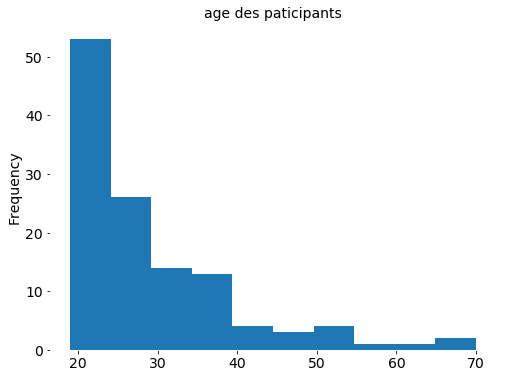

In [12]:
df.groupby('participant').mean().age_participant.plot.hist()
plt.title('age des paticipants')
plt.show()

In [17]:
df.astype(float).groupby('participant').mean().describe().iloc[:, 4:]

participant_masculin  age_participant  travail_domaine  jeux_video  \
count            121.000000       121.000000       121.000000  121.000000   
mean               0.280992        29.462810         0.008264    0.876033   
std                0.451352        10.369058         0.090909    0.330914   
min                0.000000        19.000000         0.000000    0.000000   
25%                0.000000        22.000000         0.000000    1.000000   
50%                0.000000        26.000000         0.000000    1.000000   
75%                1.000000        33.000000         0.000000    1.000000   
max                1.000000        70.000000         1.000000    1.000000   

            anime  
count  121.000000  
mean     0.760331  
std      0.428657  
min      0.000000  
25%      1.000000  
50%      1.000000  
75%      1.000000  
max      1.000000

# Statistique des avatars

In [206]:
def show_avatar():
    fig = plt.figure(figsize=(16,60))
    for idx, avatar in enumerate(avatars[:]):
        plt.subplot(num_avatar, 4, 4*idx+1)
        img=mpimg.imread('images/{}.png'.format(avatar))
        imgplot = plt.imshow(img)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([avatar-1])

        plt.subplot(num_avatar, 4, 4*idx+2)
        df[df.avatar==avatar].age.hist(bins=np.linspace(0, 100, 10))
        plt.xlabel('age')


        plt.subplot(num_avatar, 4, 4*idx+3)
        df[df.avatar==avatar].genre.hist(bins=np.linspace(0, 100, 10))
        plt.xlabel('genre')

        plt.subplot(num_avatar, 4, 4*idx+4)
        df[df.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10))
        plt.xlabel('realisme')
    plt.tight_layout()
    plt.show()

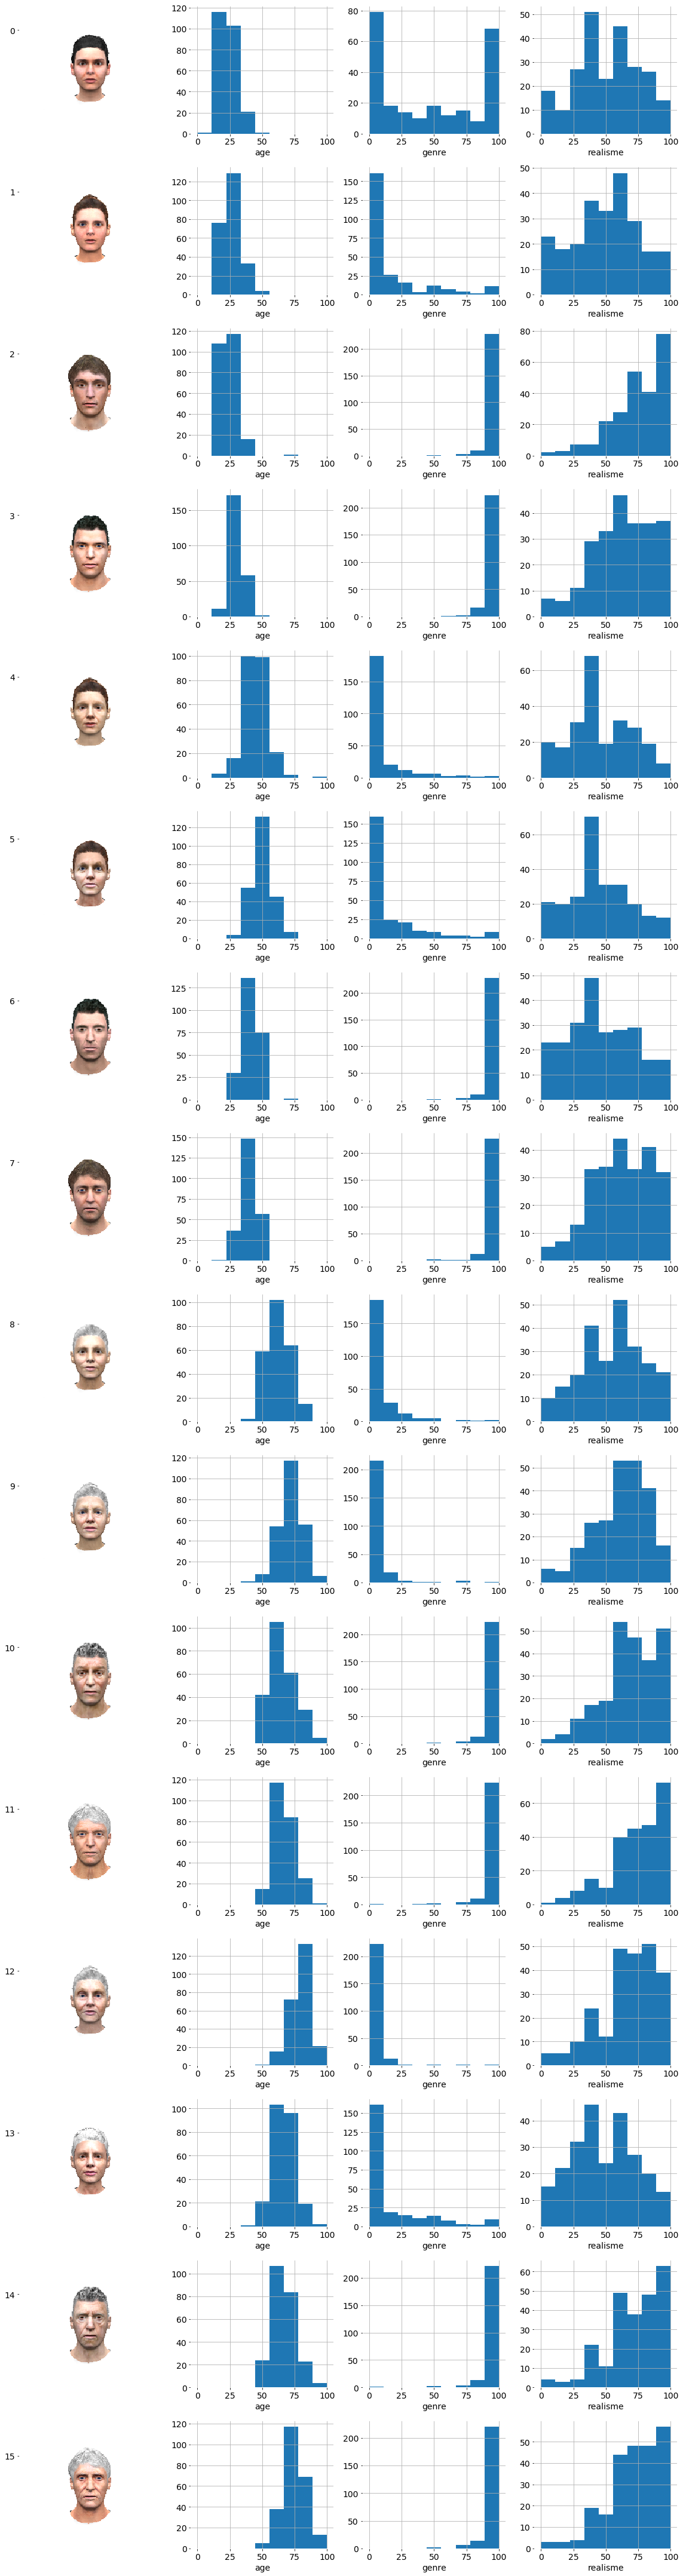

In [207]:
show_avatar()

### Concentrons-nous sur le réalisme

In [11]:
df_realisme = df.dropna(subset=['realisme'])
df_realisme[['realisme', 'avatar']].groupby('avatar').describe()

realisme                                                      
          count       mean        std  min    25%   50%    75%    max
avatar                                                               
1         242.0  51.260331  24.765171  0.0  35.25  53.5  69.00  100.0
2         242.0  49.623967  25.616448  0.0  33.25  53.0  67.00  100.0
3         242.0  74.859504  20.444564  8.0  64.00  77.0  92.00  100.0
4         242.0  62.714876  22.655944  3.0  48.00  63.5  81.75  100.0
5         242.0  45.698347  23.625798  0.0  31.25  43.0  64.00   99.0
6         242.0  44.880165  23.456106  0.0  33.00  42.0  60.00  100.0
7         242.0  46.438017  25.608088  0.0  28.00  43.5  66.75  100.0
8         242.0  61.962810  22.789190  0.0  46.25  62.0  80.00  100.0
9         242.0  54.913223  24.112218  0.0  38.00  57.0  72.75  100.0
10        242.0  61.504132  21.009432  0.0  50.00  64.0  76.75  100.0
11        242.0  68.541322  20.967282  7.0  57.00  70.0  84.75  100.0
12        242.0  73.685950  20.332315  6.0  62.00  77.0  90.00  100.0
13        242.0  67.330579  22.371028  0.0  57.00  70.0  84.00  100.0
14        242.0  48.954545  24.047369  0.0  32.00  47.0  65.00  100.0
15        242.0  71.590909  21.324844  0.0  59.00  75.0  89.00  100.0
16        242.0  71.537190  19.960975  8.0  60.00  74.0  86.75  100.0

## Premier model simple

On crée notre model génératif  
Supposons que chaque observation du réalisme pour chacun des avatars provient d'une distribution normale, ayant une moyenne et une variance.

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '212' (I am process '8752')
C:\Users\myst_\Anaconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


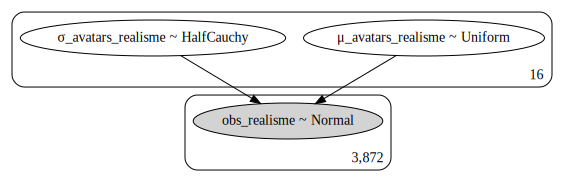

In [12]:
with pm.Model() as model_simple_realisme:
    # realisme
    ## priors
    μ_avatars_realisme = pm.Uniform('μ_avatars_realisme', 0, 100, shape=num_avatar)
    σ_avatars_realisme = pm.HalfCauchy('σ_avatars_realisme', 25, shape=num_avatar)
    
    ## obsevations
    obs_realisme = pm.Normal('obs_realisme', 
                        mu=μ_avatars_realisme[df_realisme.avatar.cat.codes], 
                        sd=σ_avatars_realisme[df_realisme.avatar.cat.codes],
                        observed=df_realisme.realisme)
    
display(model_to_graphviz(model_simple_realisme))

In [55]:
with model_simple_realisme:
    trace_simple_real = pm.sample(draws=2000, cores=cores, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (1 chains in 1 job)
NUTS: [σ_avatars_realisme, μ_avatars_realisme]
  0%|                                                 | 0/2500 [00:00<?, ?it/s]C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `

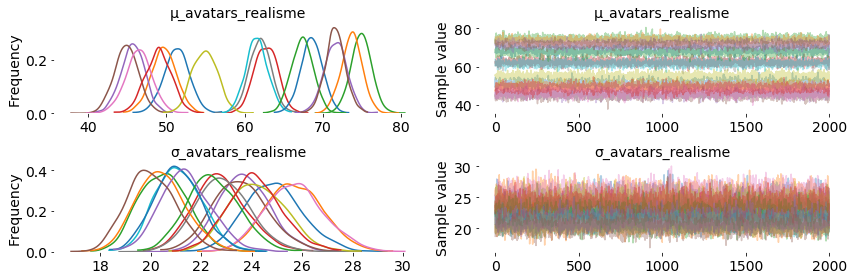

In [56]:
pm.plots.traceplot(trace_simple_real)
plt.show()

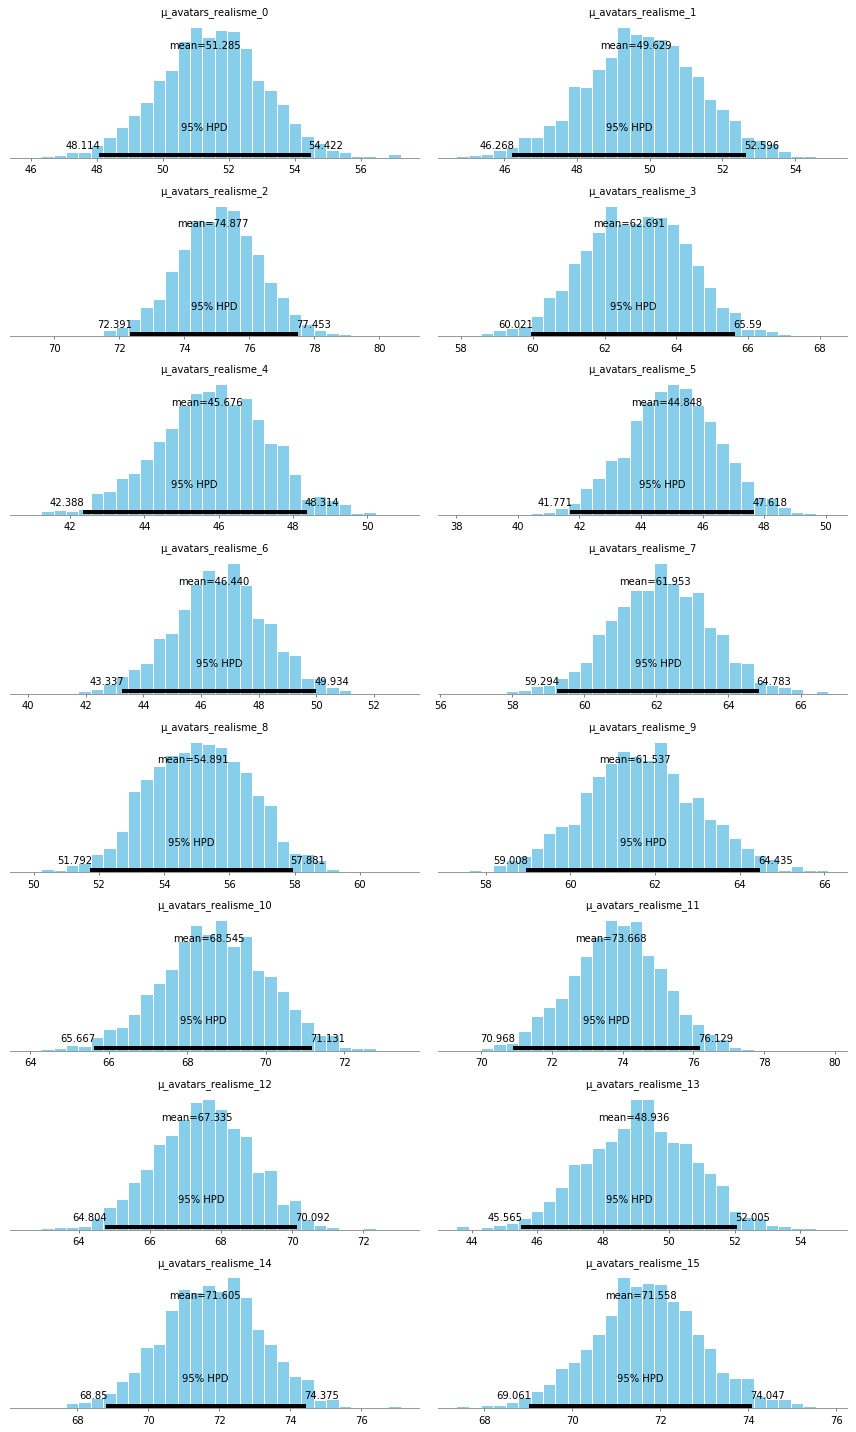

In [57]:
pm.plot_posterior(trace_simple_real, varnames=['μ_avatars_realisme'])
plt.show()

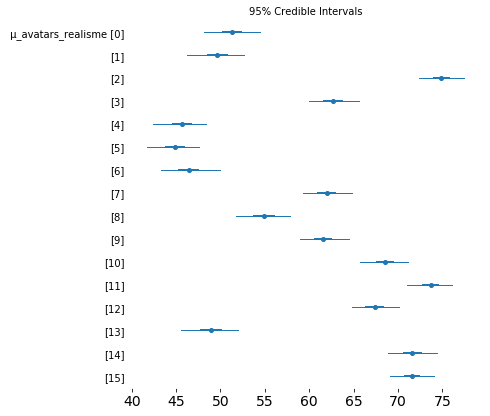

In [58]:
pm.plots.forestplot(trace_simple_real, varnames=['μ_avatars_realisme'])
plt.show()

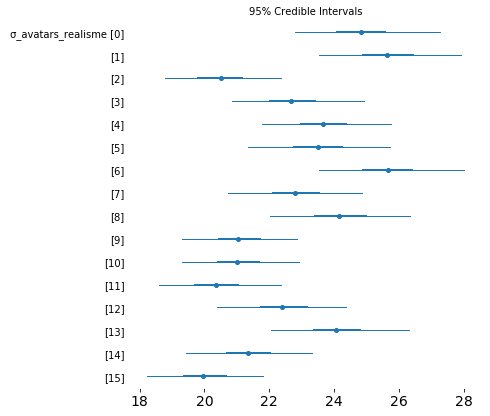

In [290]:
pm.plots.forestplot(trace_simple_real, varnames=['σ_avatars_realisme'])
plt.show()

### On peut maintenant critiquer notre modèle

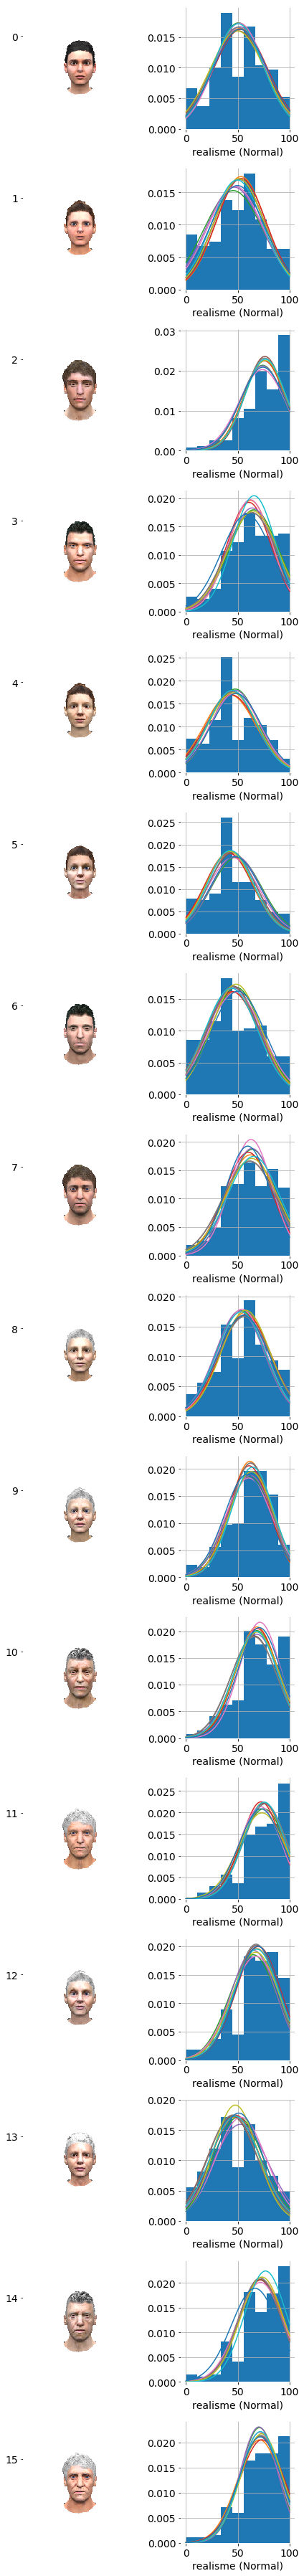

In [59]:
fig = plt.figure(figsize=(6,50))
n=10
num_plots = 2
for idx, avatar in enumerate(avatars[:]):
    
    # picture
    plt.subplot(num_avatar, num_plots, num_plots*idx+1)
    img=mpimg.imread('images/{}.png'.format(avatar))
    imgplot = plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([avatar-1])

    # Realisme normal
    plt.subplot(num_avatar, num_plots, num_plots*idx+2)
    df[df.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10), density=True)
    plt.xlabel('realisme (Normal)')
    
    x = np.linspace(0, 100, 200)
    mus = trace_simple_real['μ_avatars_realisme'][-n:, avatar-1]
    sds = trace_simple_real['σ_avatars_realisme'][-n:, avatar-1]
    a = 0
    b = 100
    for mu, sd in zip(mus, sds):
        an, bn = (a - mu) / sd, (b - mu) / sd
        pdf = stats.truncnorm.pdf(x, an,bn, loc=mu, scale=sd)
        plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(a, b))

    
    
plt.tight_layout()
plt.show()

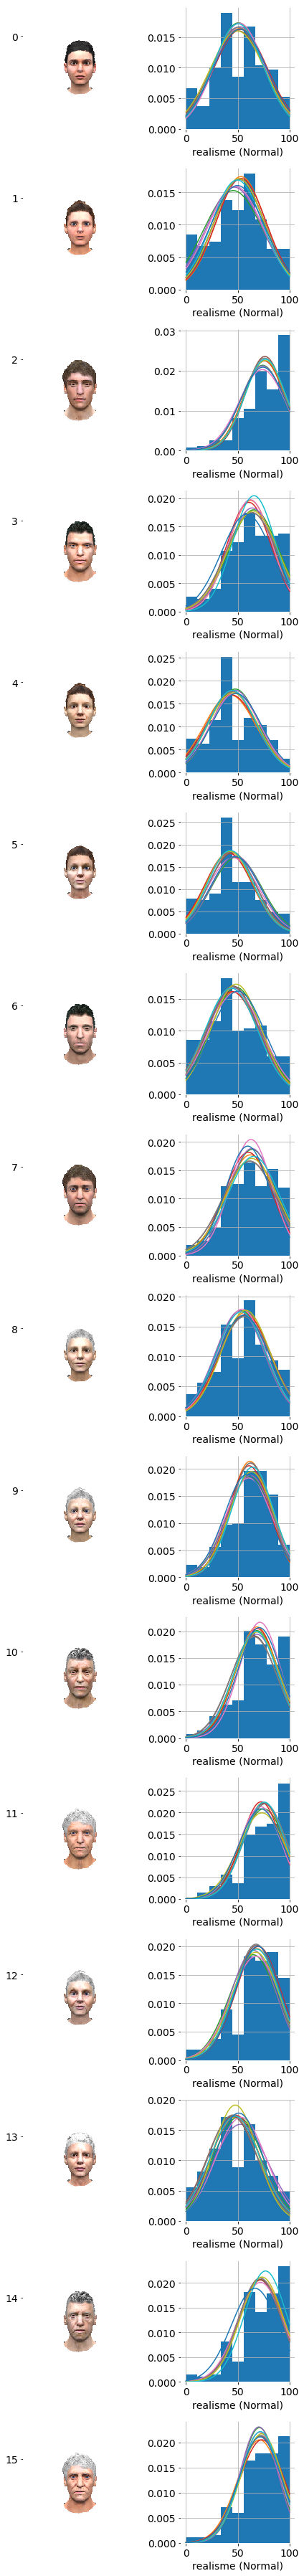

In [60]:
fig

### On remarque que nos distributions ne concordent pas tellement lorsque les observations sont près de 100
On sous-estime donc le réalisme des avatars les plus réalistes

#### Utilisons une distribution Normale tronquée
entre 0 et 100

C:\Users\myst_\Anaconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


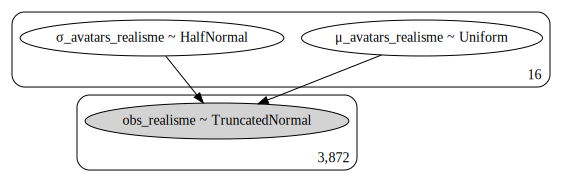

In [13]:
with pm.Model() as model_simple_realisme_tronquee:
    # realisme
    ## priors
    μ_avatars_realisme = pm.Uniform('μ_avatars_realisme', 0, 100, shape=num_avatar)
    σ_avatars_realisme = pm.HalfNormal('σ_avatars_realisme', 25, shape=num_avatar)
    
    ## obsevations
    obs_realisme = pm.TruncatedNormal('obs_realisme', 
                        mu=μ_avatars_realisme[df_realisme.avatar.cat.codes], 
                        sd=σ_avatars_realisme[df_realisme.avatar.cat.codes],
                        upper=100,
                        lower=0,
                        observed=df_realisme.realisme)
    
display(model_to_graphviz(model_simple_realisme_tronquee))

In [62]:
with model_simple_realisme_tronquee:
    trace_model_simple_realisme_tronquee = pm.sample(draws=2000, cores=cores, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_avatars_realisme, μ_avatars_realisme]
Sampling 4 chains: 100%|██████████████| 10000/10000 [05:06<00:00,  8.54draws/s]
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `a

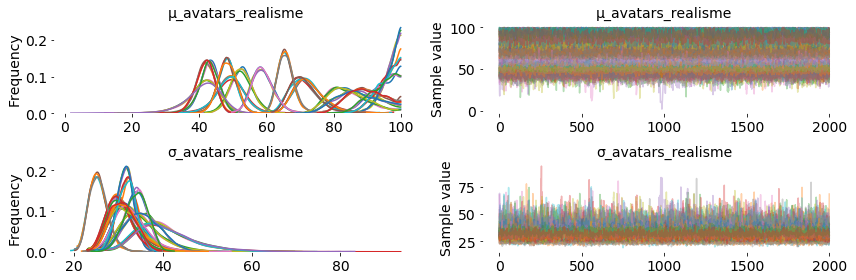

In [63]:
pm.plots.traceplot(trace_model_simple_realisme_tronquee)
plt.show()

On a permis aux moyennes d'être près des limites

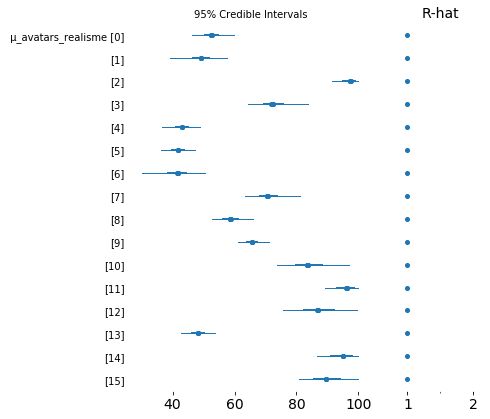

In [212]:
pm.plots.forestplot(trace_model_simple_realisme_tronquee, varnames=['μ_avatars_realisme'], chain_spacing=0)
plt.show()

### On peut maintenant comparer avec l'ancien modèle

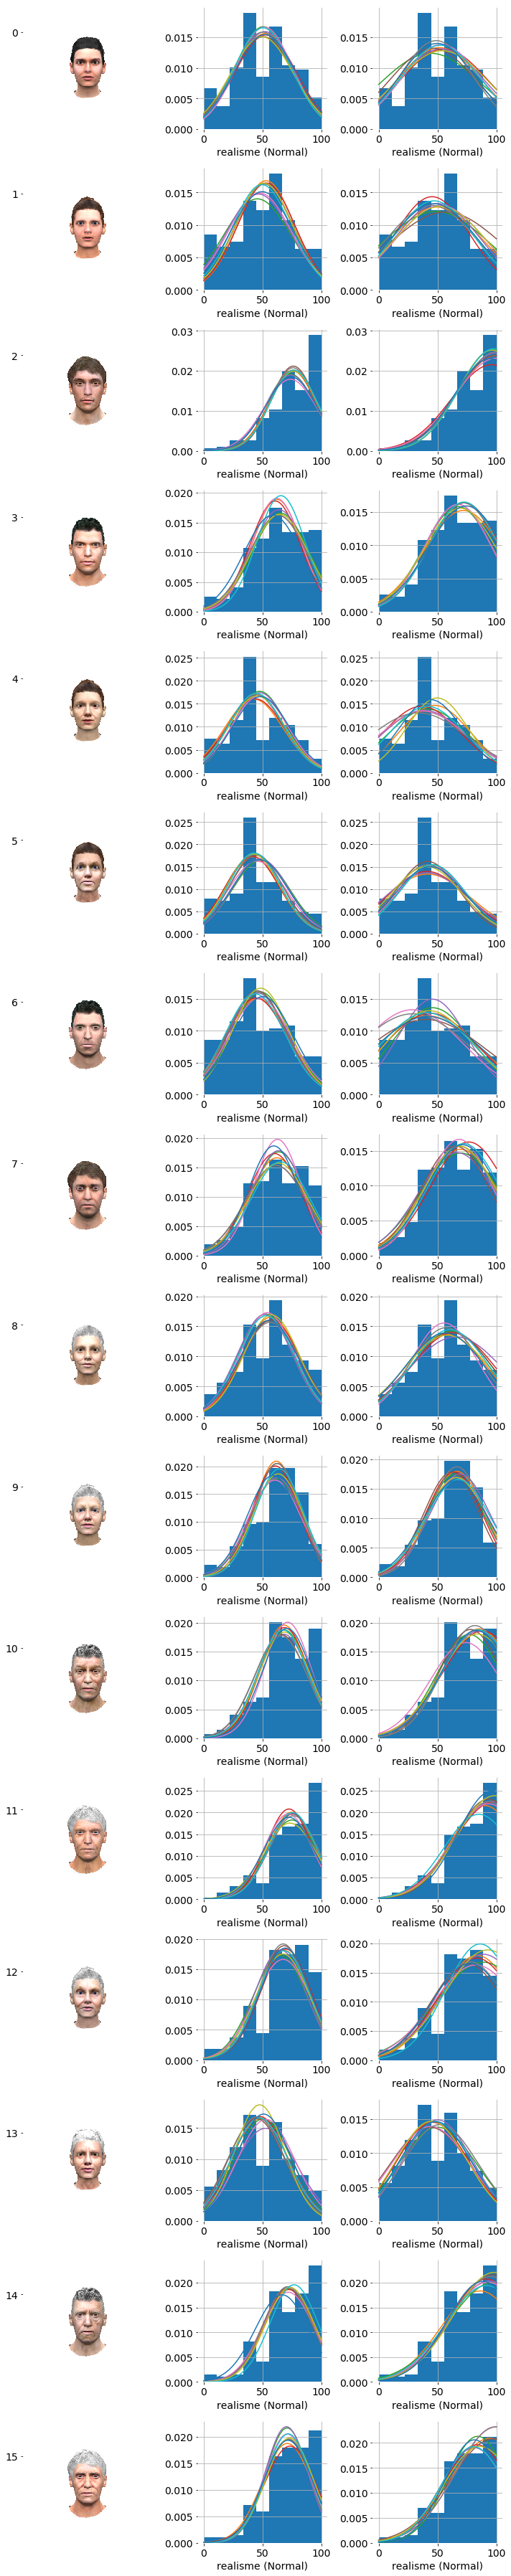

In [65]:
fig = plt.figure(figsize=(10,50))
n=10
num_plots = 3
for idx, avatar in enumerate(avatars[:]):
    
    # picture
    plt.subplot(num_avatar, num_plots, num_plots*idx+1)
    img=mpimg.imread('images/{}.png'.format(avatar))
    imgplot = plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([avatar-1])

    # Realisme Normal
    plt.subplot(num_avatar, num_plots, num_plots*idx+2)
    df[df.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10), density=True)
    plt.xlabel('realisme (Normal)')
    
    x = np.linspace(0, 100, 200)
    mus = trace_simple_real['μ_avatars_realisme'][-n:, avatar-1]
    sds = trace_simple_real['σ_avatars_realisme'][-n:, avatar-1]
    for mu, sd in zip(mus, sds):
        pdf = stats.norm.pdf(x, loc=mu, scale=sd)
        plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(a, b))
        
        
    # Realisme TruncatedNormal
    plt.subplot(num_avatar, num_plots, num_plots*idx+3)
    df[df.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10), density=True)
    plt.xlabel('realisme (Normal)')
    
    x = np.linspace(0, 100, 200)
    mus = trace_model_simple_realisme_tronquee['μ_avatars_realisme'][-n:, avatar-1]
    sds = trace_model_simple_realisme_tronquee['σ_avatars_realisme'][-n:, avatar-1]
    a = 0
    b = 100
    for mu, sd in zip(mus, sds):
        an, bn = (a - mu) / sd, (b - mu) / sd
        pdf = stats.truncnorm.pdf(x, an,bn, loc=mu, scale=sd)
        plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(a, b))

    
    
plt.tight_layout()
plt.show()

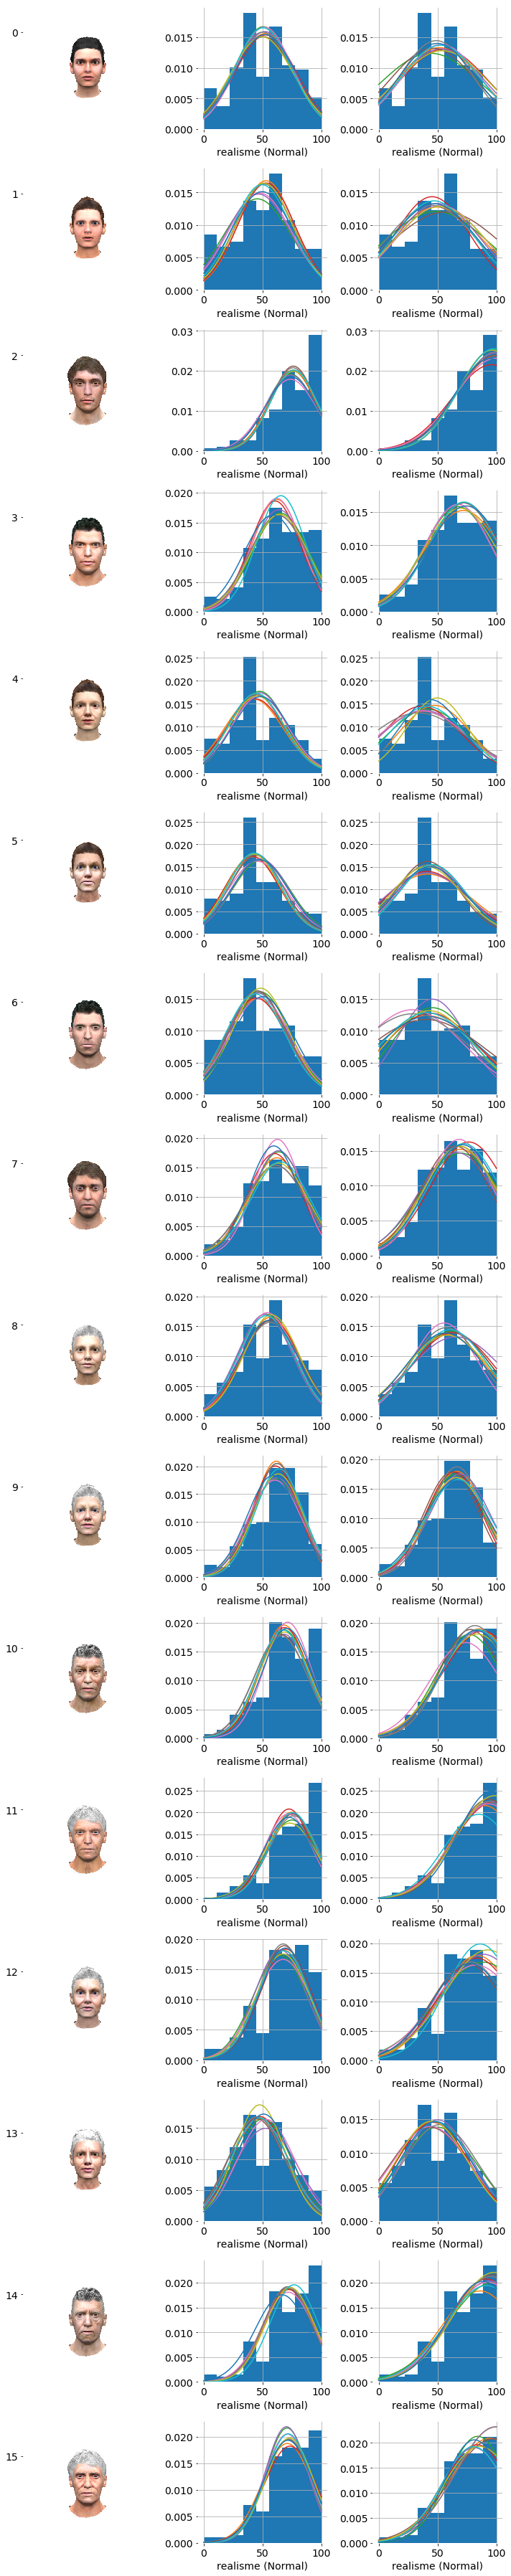

In [66]:
fig

Comparaison avec  le Widely Available Information Criterion

In [67]:
model_simple_realisme_tronquee.name = 'Normale Tronquée'
model_simple_realisme.name = 'Normale'
pm.compare({model_simple_realisme_tronquee:trace_model_simple_realisme_tronquee,
           model_simple_realisme:trace_simple_real})

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


WAIC  pWAIC   dWAIC weight     SE    dSE var_warn
Normale Tronquée  34349.3  31.28       0      1  63.11      0        0
Normale           35187.6  30.32  838.26      0  84.36  41.76        0

### On peut à présent analyser nos inférence pour répondre à notre question:
> Quels sont les avatars les plus réalistes?

In [284]:
pd.DataFrame(data={'realisme':trace_model_simple_realisme_tronquee['μ_avatars_realisme'].mean(axis=0), 'avatar':np.arange(1,17)}).sort_values('realisme', ascending=False).set_index('avatar').head()

realisme
avatar           
3       96.772936
12      95.535196
15      94.267306
16      89.654039
13      87.179722

Par contre, ces inférences sont affectés par le biais de notre échantillon, e.g. majoritairement des femmes dans la vingtaine.  

Aussi, certains participants peuvent avoir un fort biais ayant un grand impact sur nos réponses.

Essayons de régler ces problèmes

## Bâtissons un modèle hierarchique

Permettons à chacun des participants d'être biaisés.  
On veut aussi estimer quelle est la variance dans le biais du groupe de participants

In [14]:
with pm.Model() as model_herarchical_real:
    # Age
    ## priors
    σ_group = pm.HalfCauchy('σ_group', 20)
    
    μ_participant_bias_realisme = pm.Normal('μ_participant_bias_realisme', mu=0, sd=σ_group, shape=num_participant)
    
    μ_avatars_realisme = pm.Uniform('μ_avatars_realisme', 0, 100, shape=num_avatar)
    σ_avatars_realisme = pm.HalfCauchy('σ_avatars_realisme', 3, shape=num_avatar)
    
    ## obsevations
    obs_realisme = myNormal('obs_realisme', 
                        mu=μ_avatars_realisme[df_realisme.avatar.cat.codes] + μ_participant_bias_realisme[df_realisme.participant.cat.codes], 
                        sd=σ_avatars_realisme[df_realisme.avatar.cat.codes],  
                        observed=df_realisme.realisme)

C:\Users\myst_\Anaconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


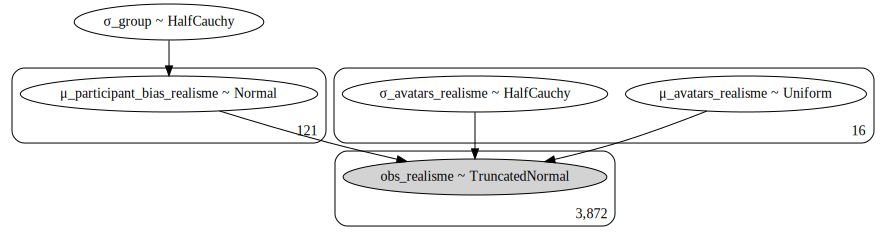

In [15]:
display(model_to_graphviz(model_herarchical_real))

In [69]:
with model_herarchical_real:
    trace_model_herarchical_real = pm.sample(draws=2000, cores=cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_avatars_realisme, μ_avatars_realisme, μ_participant_bias_realisme, σ_group]
Sampling 4 chains: 100%|██████████████| 10000/10000 [06:50<00:00, 24.39draws/s]
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

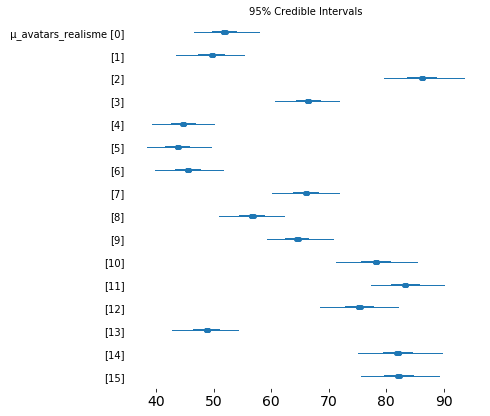

In [231]:
pm.plots.forestplot(trace_model_herarchical_real, varnames=['μ_avatars_realisme'], rhat=False, chain_spacing=0)
plt.show()

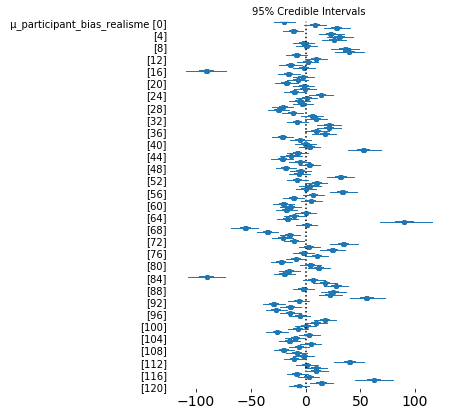

In [232]:
pm.plots.forestplot(trace_model_herarchical_real, varnames=['μ_participant_bias_realisme'], rhat=False, chain_spacing=0)
plt.yticks(plt.yticks()[0], ['' if idx%4 else y for (idx, y) in enumerate(plt.yticks()[1]) ])
plt.show()

On peut toujours comparer avec les autres modèles

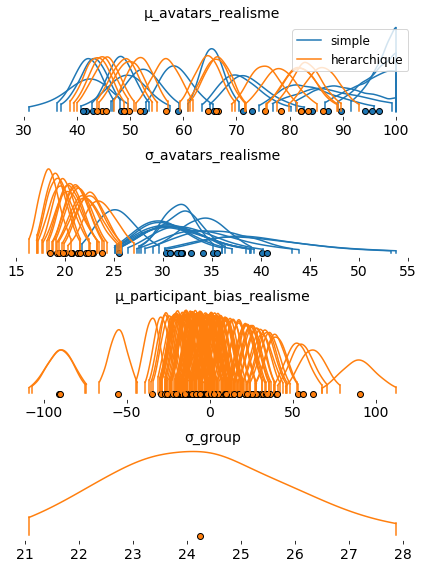

In [241]:
pm.densityplot([trace_model_simple_realisme_tronquee, trace_model_herarchical_real], models=['simple', 'herarchique'])
plt.show()

In [72]:
model_simple_realisme_tronquee.name = 'Normale Tronquée'
model_simple_realisme.name = 'Normale'
model_herarchical_real.name = 'Herarchique'

pm.compare({model_simple_realisme_tronquee:trace_model_simple_realisme_tronquee,
           model_simple_realisme:trace_simple_real,
           model_herarchical_real:trace_model_herarchical_real})

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\pymc3\stats.py:211: UserW

WAIC   pWAIC    dWAIC weight     SE     dSE var_warn
Herarchique       32357.7  151.26        0   0.97  91.74       0        1
Normale Tronquée  34349.3   31.28  1991.65   0.03  63.11   89.89        0
Normale           35187.6   30.32  2829.91      0  84.36  108.52        0

## Modélisons maintenant en incluant plusieurs prédicteurs

In [16]:
with pm.Model() as model_herarchical_real_all_bias_par:
    ## priors
    
    ### Influence de l'avatar
    μ_avatars_realisme = pm.Uniform('μ_avatars_realisme', 0, 100, shape=num_avatar)
    σ_avatars_realisme = pm.HalfCauchy('σ_avatars_realisme', 20, shape=num_avatar)
    
    β_avatar_genre = pm.Normal('β_avatar_genre', mu=0, sd=10)
    β_avatar_age = pm.Normal('β_avatar_age', mu=0, sd=10)
    
    avatar_is_male = df.groupby('avatar').genre.mean() > 50
    avatar_age_c     = df.groupby('avatar').age.mean() - df.age.mean()
    
    μ_avatar_bias_realisme = pm.Deterministic('μ_avatar_bias_realisme', 
                              μ_avatars_realisme[df_realisme.avatar.cat.codes]
                              + β_avatar_genre*avatar_is_male[df_realisme.avatar]
                              + β_avatar_age * avatar_age_c[df_realisme.avatar]
                             )
    
    ### Influence du participant
    σ_group = pm.HalfCauchy('σ_group', 20)
    μ_participant_intercept = pm.Normal('μ_participant_intercept', mu=0, sd=σ_group, shape=num_participant)
    
    
    β_age_par = pm.Normal('β_age_par', mu=0, sd=10)
    β_ismale_participant = pm.Normal('β_ismale_participant', mu=0, sd=10)
    β_videogame_par = pm.Normal('β_videogame_par', mu=0, sd=10)
    β_anime_par = pm.Normal('β_anime_par', mu=0, sd=10)
    β_travail_par = pm.Normal('β_travail_par', mu=0, sd=10)
    
    age_participant_c = df_realisme.age_participant - df_realisme.age_participant.mean()
    
    μ_participant_bias_realisme = pm.Deterministic('μ_participant_bias_realisme',
                                              μ_participant_intercept[df_realisme.participant.cat.codes]
                                              + β_age_par*age_participant_c
                                              + β_ismale_participant*df_realisme.participant_masculin
                                              + β_videogame_par*df_realisme.jeux_video
                                              + β_anime_par*df_realisme.anime
                                              + β_travail_par*df_realisme.travail_domaine)
    
    ## Interactions
    γ_avatar_par_same_genre = pm.Normal('γ_avatar_par_same_genre', mu=0, sd=10)
    avatar_par_same_genre = np.logical_not(np.logical_xor(df_realisme.participant_masculin, avatar_is_male[df_realisme.avatar])).values
    μ_interations =  γ_avatar_par_same_genre * avatar_par_same_genre
    
    
    ## obsevations
    obs_realisme = myNormal('obs_realisme', 
                        mu=μ_avatar_bias_realisme + μ_participant_bias_realisme + μ_interations, 
                        sd=σ_avatars_realisme[df_realisme.avatar.cat.codes], 
                        observed=df_realisme.realisme)

graph = model_to_graphviz(model_herarchical_real_all_bias_par)
graph.graph_attr.update(rankdir='LR', size='8')

C:\Users\myst_\Anaconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\myst_\Anaconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


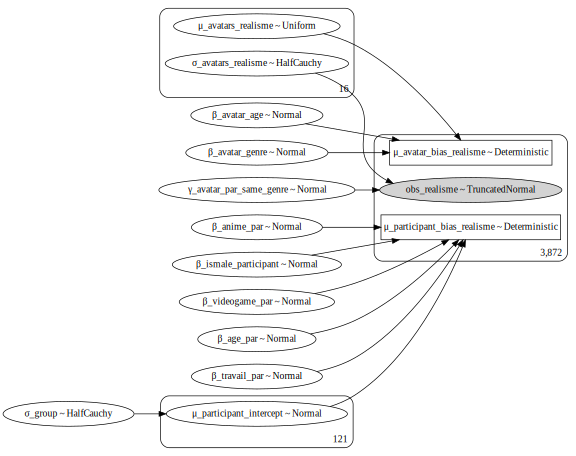

In [17]:
display(graph)

In [75]:
with model_herarchical_real_all_bias_par:
    trace_model_herarchical_real_all_bias_par = pm.sample(draws=2000, cores=cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ_avatar_par_same_genre, β_travail_par, β_anime_par, β_videogame_par, β_ismale_participant, β_age_par, μ_participant_intercept, σ_group, β_avatar_age, β_avatar_genre, σ_avatars_realisme, μ_avatars_realisme]
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

#### Les prédicteurs liés au participant

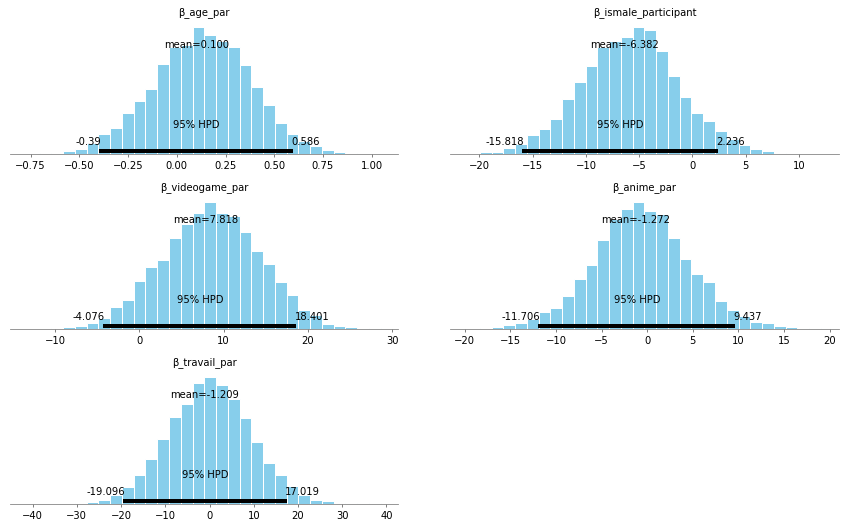

In [291]:
pm.plot_posterior(trace_model_herarchical_real_all_bias_par, varnames=['β_age_par', 'β_ismale_participant', 'β_videogame_par', 'β_anime_par', 'β_travail_par',])
plt.show()

#### Les prédicteurs liés à l'avatar

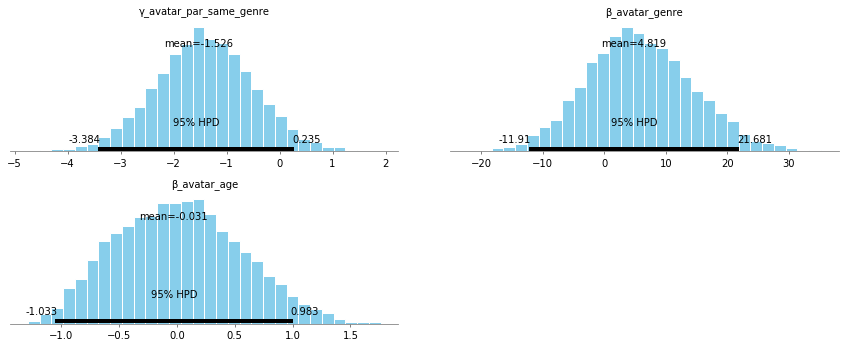

In [77]:
pm.plot_posterior(trace_model_herarchical_real_all_bias_par, varnames=['γ_avatar_par_same_genre', 'β_avatar_genre', 'β_avatar_age',])
plt.show()

In [78]:
varnames=['γ_avatar_par_same_genre', 'β_avatar_genre', 'β_avatar_age',
          'β_age_par', 'β_ismale_participant', 'β_videogame_par', 'β_anime_par', 'β_travail_par', 
          'σ_group']

display(pm.summary(trace_model_herarchical_real_all_bias_par, varnames=varnames))

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


mean        sd  mc_error    hpd_2.5   hpd_97.5  \
γ_avatar_par_same_genre  -1.526037  0.926525  0.010709  -3.383848   0.234748   
β_avatar_genre            4.819412  8.649759  0.234488 -11.910372  21.680730   
β_avatar_age             -0.031256  0.536783  0.024634  -1.033319   0.983322   
β_age_par                 0.099582  0.249489  0.009653  -0.389699   0.585978   
β_ismale_participant     -6.382045  4.558280  0.177467 -15.817828   2.235573   
β_videogame_par           7.817785  5.819751  0.236503  -4.076085  18.400854   
β_anime_par              -1.271898  5.288507  0.236780 -11.705897   9.437124   
β_travail_par            -1.209423  9.285535  0.124479 -19.095975  17.018552   
σ_group                  24.190887  1.790873  0.026641  20.759447  27.697196   

                               n_eff      Rhat  
γ_avatar_par_same_genre  8823.921730  0.999888  
β_avatar_genre           1327.265357  1.000519  
β_avatar_age              416.047977  1.000743  
β_age_par                 531.739566  1.005368  
β_ismale_participant      528.019155  1.003485  
β_videogame_par           583.807836  1.007140  
β_anime_par               488.724600  1.000775  
β_travail_par            4274.942245  0.999964  
σ_group                  3986.282863  0.999788

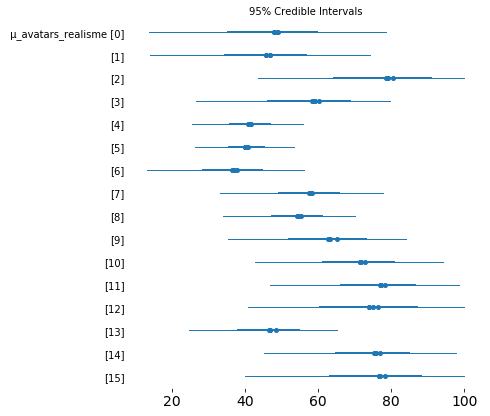

In [79]:
pm.plots.forestplot(trace_model_herarchical_real_all_bias_par, varnames=['μ_avatars_realisme'], rhat=False, chain_spacing=0)
plt.show()

On peut toujours comparer avec les autres modèles

In [81]:
model_simple_realisme_tronquee.name = 'Normale Tronquée'
model_simple_realisme.name = 'Normale'
model_herarchical_real.name = 'Herarchique'
model_herarchical_real_all_bias_par.name = 'Herarchique + covariables'

pm.compare({model_simple_realisme_tronquee:trace_model_simple_realisme_tronquee,
           model_simple_realisme:trace_simple_real,
           model_herarchical_real:trace_model_herarchical_real,
           model_herarchical_real_all_bias_par:trace_model_herarchical_real_all_bias_par,
           })

C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

WAIC   pWAIC    dWAIC weight     SE     dSE  \
Herarchique                32357.7  151.26        0    0.8  91.74       0   
Herarchique + covariables  32358.7  152.05     1.03   0.17  91.28    3.48   
Normale Tronquée           34349.3   31.28  1991.65   0.03  63.11   89.89   
Normale                    35187.6   30.32  2829.91      0  84.36  108.52   

                          var_warn  
Herarchique                      1  
Herarchique + covariables        1  
Normale Tronquée                 0  
Normale                          0

## Simulation
En plus d'interpréter les données et de mieux comprendre les interactions entre le modèle et les différentes vairable, on peut utiliser notre modèle pour générer des données et simuler un nouvel échantillion, tout en gardant la notion d'incertitude/plausibilité.

### Simulons un échantillon provennant d'une population plus diverse que celle obtenue par les liste de courriels de l'Université

In [20]:
num_par_sim = 1

# data
## participant
age_participant_c = df_realisme.age_participant - df_realisme.age_participant.mean()
age_participant_c = theano.shared(age_participant_c.values)

participant_masculin = theano.shared(df_realisme.participant_masculin.values)
jeux_video = theano.shared(df_realisme.jeux_video.values)
anime = theano.shared(df_realisme.anime.values)
travail_domaine = theano.shared(df_realisme.travail_domaine.values)

participant_cat_code = theano.shared(df_realisme.participant.cat.codes.astype(np.uint16).values)

## avatar

avatar_is_male = df.groupby('avatar').genre.mean() > 50
avatar_age_c     = df.groupby('avatar').age.mean() - df.age.mean()

avatar_is_male = theano.shared(avatar_is_male.values)
avatar_age_c   = theano.shared(avatar_age_c.values)

avatar_cat_code = theano.shared(df_realisme.avatar.cat.codes.values)

## interaction

avatar_par_same_genre = theano.shared(np.logical_not(np.logical_xor(df_realisme.participant_masculin.values, avatar_is_male.get_value()[avatar_cat_code.get_value()])))

## observation
y = theano.shared(df_realisme.realisme.values)


with pm.Model() as model_herarchical_simulation:
    ## priors
    
    ### Influence de l'avatar
    μ_avatars_realisme = pm.Uniform('μ_avatars_realisme', 0, 100, shape=num_avatar)
    σ_avatars_realisme = pm.HalfCauchy('σ_avatars_realisme', 20, shape=num_avatar)
    
    β_avatar_genre = pm.Normal('β_avatar_genre', mu=0, sd=10)
    β_avatar_age = pm.Normal('β_avatar_age', mu=0, sd=10)
    
    μ_avatar_bias_realisme = pm.Deterministic('μ_avatar_bias_realisme', 
                              μ_avatars_realisme[avatar_cat_code]
                              + β_avatar_genre * avatar_is_male[avatar_cat_code]
                              + β_avatar_age   * avatar_age_c[avatar_cat_code]
                             )
    
    ### Influence du participant
    σ_group = pm.HalfCauchy('σ_group', 20)
    μ_participant_intercept = pm.Normal('μ_participant_intercept', mu=0, sd=σ_group, shape=num_participant+num_par_sim)
    
    
    β_age_par = pm.Normal('β_age_par', mu=0, sd=10)
    β_ismale_participant = pm.Normal('β_ismale_participant', mu=0, sd=10)
    β_videogame_par = pm.Normal('β_videogame_par', mu=0, sd=10)
    β_anime_par = pm.Normal('β_anime_par', mu=0, sd=10)
    β_travail_par = pm.Normal('β_travail_par', mu=0, sd=10)
        
    μ_participant_bias_realisme = pm.Deterministic('μ_participant_bias_realisme',
                                              μ_participant_intercept[participant_cat_code]
                                              + β_age_par*age_participant_c
                                              + β_ismale_participant*participant_masculin
                                              + β_videogame_par*jeux_video
                                              + β_anime_par*anime
                                              + β_travail_par*travail_domaine)
    
    ## Interactions
    γ_avatar_par_same_genre = pm.Normal('γ_avatar_par_same_genre', mu=0, sd=10)
    μ_interations =  γ_avatar_par_same_genre * avatar_par_same_genre
    
    
    ## obsevations
    obs_realisme = myNormal('obs_realisme', 
                        mu=μ_avatar_bias_realisme + μ_participant_bias_realisme + μ_interations, 
                        sd=σ_avatars_realisme[avatar_cat_code], 
                        observed=y)

In [21]:
with model_herarchical_simulation:
    trace_model_herarchical_simulation = pm.sample(draws=2000, cores=cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ_avatar_par_same_genre, β_travail_par, β_anime_par, β_videogame_par, β_ismale_participant, β_age_par, μ_participant_intercept, σ_group, β_avatar_age, β_avatar_genre, σ_avatars_realisme, μ_avatars_realisme]
Sampling 4 chains: 100%|██████████████| 10000/10000 [24:39<00:00,  2.34draws/s]
C:\Users\alfoc.ULAVAL\AppData\Local\Continuum\miniconda3\envs\data-science\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 10% for some parameters.


In [23]:
num_values = 32 # 1 participant

age_participant_c.set_value( np.linspace(18, 80, num_values) - df_realisme.age_participant.mean())
participant_masculin.set_value(np.random.randint(0, 2, num_values).astype(bool))
jeux_video.set_value(np.random.randint(0, 2, num_values).astype(bool))
anime.set_value(np.random.randint(0, 2, num_values).astype(bool))
travail_domaine.set_value(np.random.randint(0, 20, num_values)>0)

#participant_cat_code.set_value(df_realisme.participant.values.astype(np.uint16))
participant_cat_code.set_value(df_realisme.participant.values.astype(np.uint16)[:num_values]*0 + 121)

avatar_cat_code.set_value(avatar_cat_code.get_value()[:num_values])

avatar_par_same_genre.set_value(np.logical_not(np.logical_xor(participant_masculin.get_value(), avatar_is_male.get_value()[avatar_cat_code.get_value()])))

y.set_value(np.zeros(num_values))


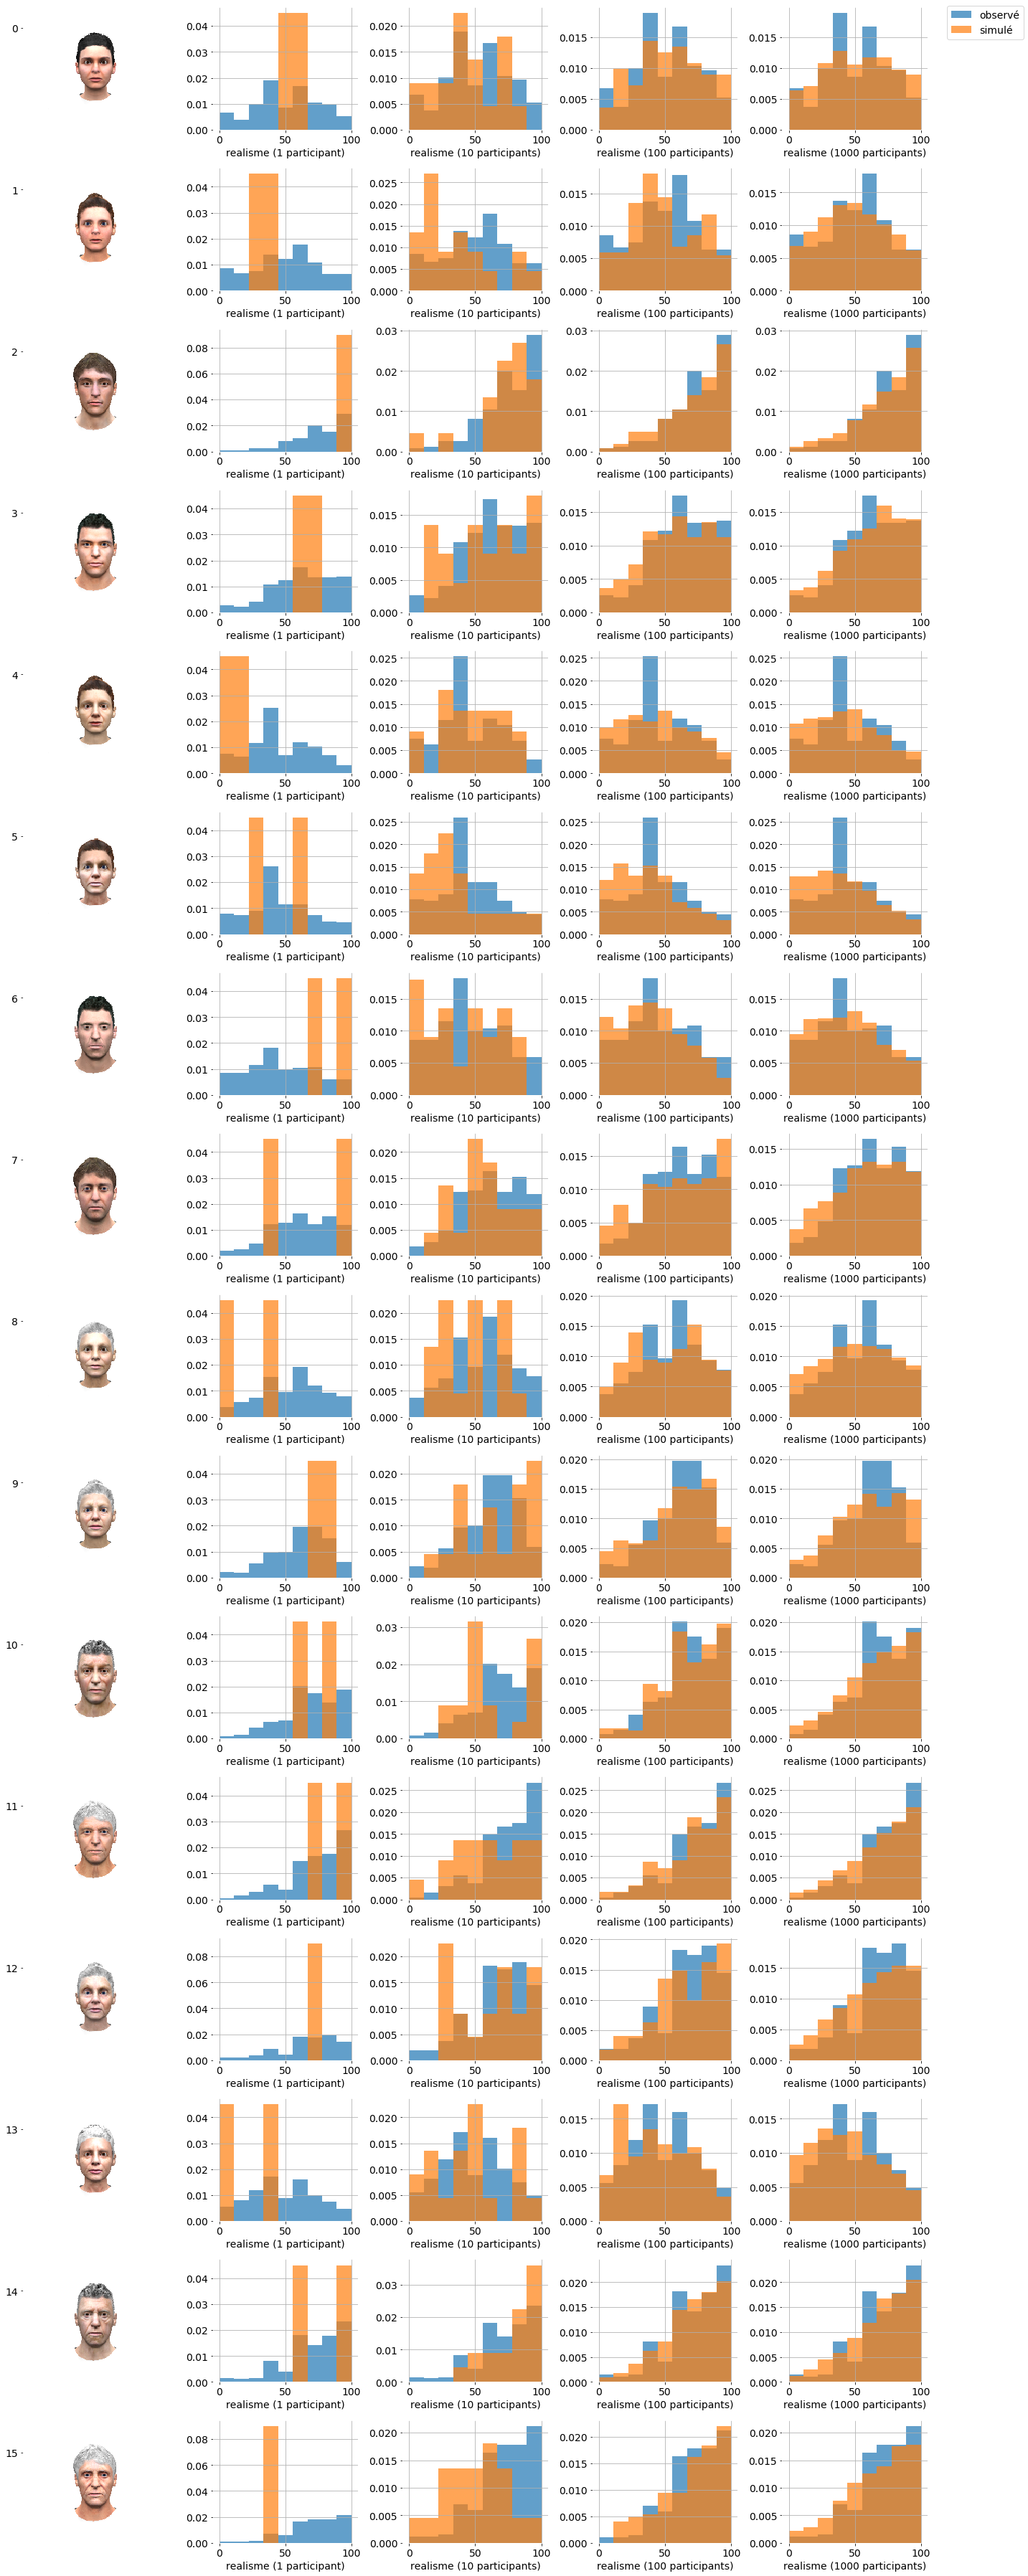

In [24]:
fig = plt.figure(figsize=(20,50))
n=10
num_plots = 5
for idx, avatar in enumerate(avatars[:]):
    
    # picture
    plt.subplot(num_avatar, num_plots, num_plots*idx+1)
    img=mpimg.imread('images/{}.png'.format(avatar))
    imgplot = plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([avatar-1])

    # Realisme
    plt.subplot(num_avatar, num_plots, num_plots*idx+2)
    df_realisme[df_realisme.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10), density=True, alpha=0.7, label='observé')
    
    # Realisme sim
    samples = pm.sample_ppc(trace_model_herarchical_simulation, model=model_herarchical_simulation, progressbar=False, samples=1, size=1, vars=[obs_realisme, μ_avatar_bias_realisme])
    df_sim = pd.DataFrame(np.vstack((avatar_cat_code.get_value()+1, samples['obs_realisme'],))).T
    df_sim = df_sim.rename(columns={0:'avatar'})
    df_sim = df_sim.melt('avatar', value_name='realisme')[['avatar', 'realisme']]

    df_sim[df_sim.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10), density=True, alpha=0.7, label='simulé')
    plt.xlabel('realisme (1 participant)')
    
    # Realisme
    plt.subplot(num_avatar, num_plots, num_plots*idx+3)
    df_realisme[df_realisme.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10), density=True, alpha=0.7, label='observé')
    
    # Realisme sim
    samples = pm.sample_ppc(trace_model_herarchical_simulation, model=model_herarchical_simulation, progressbar=False, samples=10, size=1, vars=[obs_realisme, μ_avatar_bias_realisme])
    df_sim = pd.DataFrame(np.vstack((avatar_cat_code.get_value()+1, samples['obs_realisme'],))).T
    df_sim = df_sim.rename(columns={0:'avatar'})
    df_sim = df_sim.melt('avatar', value_name='realisme')[['avatar', 'realisme']]

    df_sim[df_sim.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10), density=True, alpha=0.7, label='simulé')
    plt.xlabel('realisme (10 participants)')
    
    # Realisme
    plt.subplot(num_avatar, num_plots, num_plots*idx+4)
    df_realisme[df_realisme.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10), density=True, alpha=0.7, label='observé')
    
    # Realisme sim
    samples = pm.sample_ppc(trace_model_herarchical_simulation, model=model_herarchical_simulation, progressbar=False, samples=100, size=1, vars=[obs_realisme, μ_avatar_bias_realisme])
    df_sim = pd.DataFrame(np.vstack((avatar_cat_code.get_value()+1, samples['obs_realisme']))).T
    df_sim = df_sim.rename(columns={0:'avatar'})
    df_sim = df_sim.melt('avatar', value_name='realisme')[['avatar', 'realisme']]

    df_sim[df_sim.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10), density=True, alpha=0.7, label='simulé')
    plt.xlabel('realisme (100 participants)')
    
    # Realisme
    plt.subplot(num_avatar, num_plots, num_plots*idx+5)
    df_realisme[df_realisme.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10), density=True, alpha=0.7, label='observé')
    
    # Realisme sim
    samples = pm.sample_ppc(trace_model_herarchical_simulation, model=model_herarchical_simulation, progressbar=False, samples=1000, size=1, vars=[obs_realisme, μ_avatar_bias_realisme])
    df_sim = pd.DataFrame(np.vstack((avatar_cat_code.get_value()+1, samples['obs_realisme']))).T
    df_sim = df_sim.rename(columns={0:'avatar'})
    df_sim = df_sim.melt('avatar', value_name='realisme')[['avatar', 'realisme']]

    df_sim[df_sim.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10), density=True, alpha=0.7, label='simulé')
    plt.xlabel('realisme (1000 participants)')
    

    
    if idx==0:
        plt.legend(bbox_to_anchor=(1.1, 1.05))
    
    #plt.text(100, 0.006, 'obs mean : {:.2f}'.format(df_realisme[df_realisme.avatar==avatar].realisme.mean()), fontsize=14)
    #plt.text(100, 0.004, 'sim mean : {:.2f}'.format(df_sim[df_sim.avatar==avatar].realisme.mean()), fontsize=14)
    #plt.text(100, 0.002, 'diff mean : {:.2f}'.format(- df_realisme[df_realisme.avatar==avatar].realisme.mean() + df_sim[df_sim.avatar==avatar].realisme.mean()), fontsize=14)
    

plt.tight_layout()


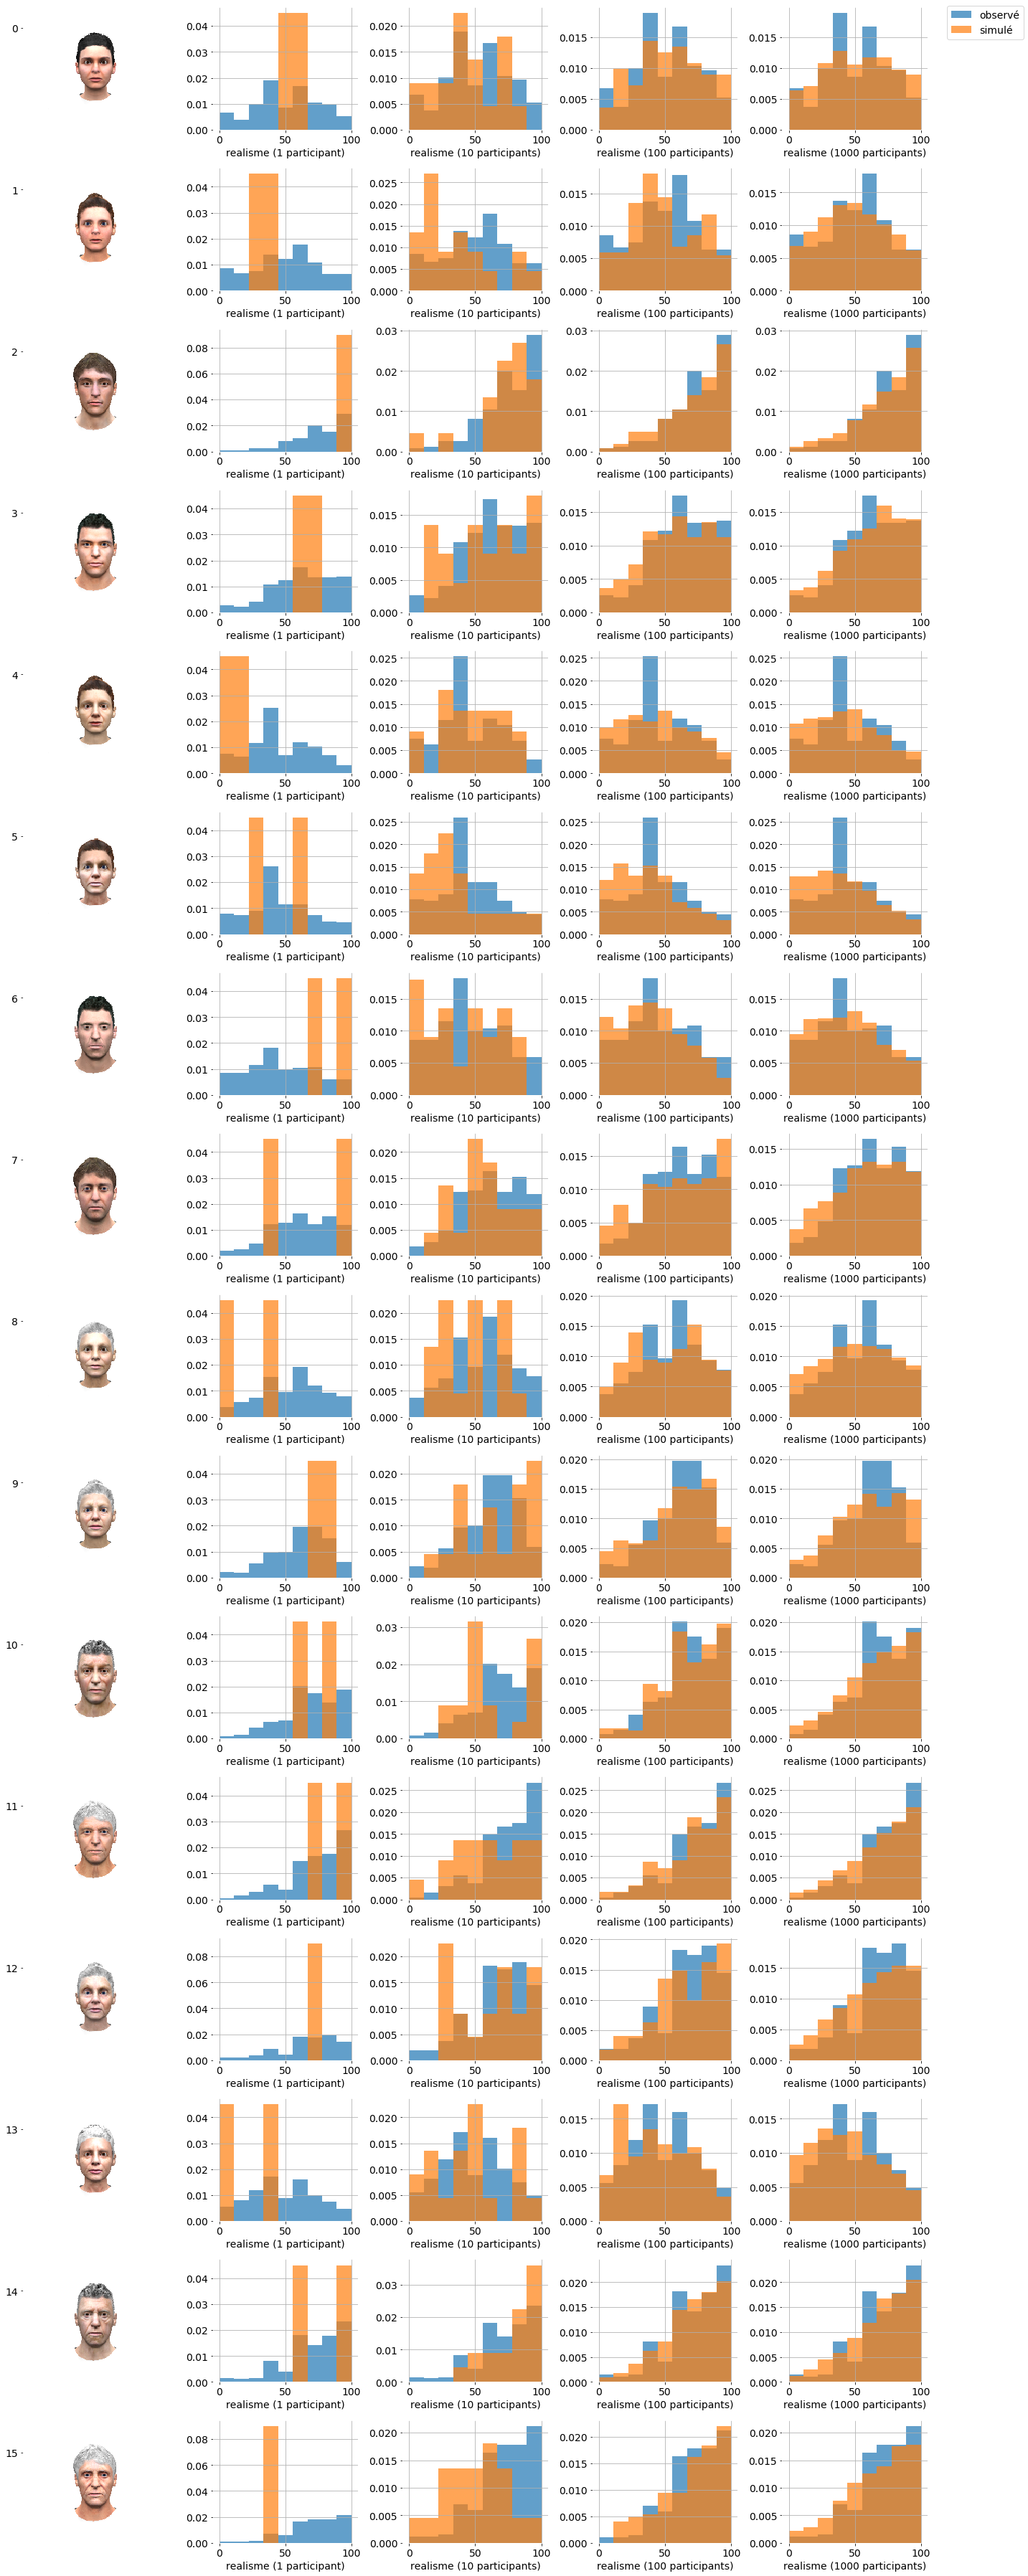

In [25]:
fig

## Finalement on peut comparer quels sont les avatars les plus réalistes en fonction du modèle

In [340]:
samples = pm.sample_ppc(trace_model_herarchical_simulation, model=model_herarchical_simulation, progressbar=False, samples=1000, size=1, vars=[μ_avatar_bias_realisme, μ_participant_bias_realisme, μ_interations])
realisme = samples['μ_avatar_bias_realisme'] + samples['μ_participant_bias_realisme'] + samples[None]
df_new = pd.DataFrame(data={'realisme population variée':realisme.mean(axis=0), 'avatar ':avatar_cat_code.get_value()+1}).groupby('avatar ').mean().sort_values('realisme population variée', ascending=False)

df_old = pd.DataFrame(data={'realisme échantillion orig.':trace_model_simple_realisme_tronquee['μ_avatars_realisme'].mean(axis=0), 'avatar':np.arange(1,17)}).sort_values('realisme échantillion orig.', ascending=False).set_index('avatar')

In [346]:
pd.concat([df_old.reset_index(), df_new.reset_index()] ,axis=1).head(8).style.hide_index()

# Pour plus d'info

### Statistiques bayésiennes

<table>
    <tr>
        <td>
            <a href="https://bayesmodels.com/"><img src="https://images-na.ssl-images-amazon.com/images/I/51K33XI2I8L._SX330_BO1,204,203,200_.jpg " width="250"></a>
        </td>
        <td>
            <a href="https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3"><img src="http://xcelab.net/rm/wp-content/uploads/2012/01/9781482253443.jpg" width="250"></a>
        </td>
        <td>
            <a href="https://www.amazon.ca/Doing-Bayesian-Data-Analysis-Tutorial/dp/0124058884/ref=dp_ob_image_bk"><img src="https://images-na.ssl-images-amazon.com/images/I/51LLy0AWDpL._SX404_BO1,204,203,200_.jpg" width="250"></a>
        </td>
        <td>
            <a href="https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers#pymc3"><img src="https://camo.githubusercontent.com/4a0aca82ca82efab71747d00db30f3a68de98e82/687474703a2f2f692e696d6775722e636f6d2f36444b596250622e706e673f31" width="300"></a>
            <br>
        </td>
    </tr>
</table>

Plusieurs sont disponible à la bibliothèque ou en ligne avec [Ariane 2.0](http://arianeweb.ulaval.ca/ariane/wicket/accueil)

# Échosystème de programmation probabiliste

<table>
    <tr>
        <th>Probabilistic Programming System</th>
        <th>Language</th>
        <th>License</th>
        <th>Discrete Variable Support</th>
        <th>Automatic Differentiation/Hamiltonian Monte Carlo</th>
        <th>Variational Inference</th>
    </tr>
    <tr>
        <td><a href='http://pymc-devs.github.io/pymc3/'>PyMC3</a></td>
        <td>Python</td>
        <td>Apache V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href='http://mc-stan.org/'>Stan</a></td>
        <td>C++, R, Python, ...</td>
        <td>BSD 3-clause</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href="http://edwardlib.org/">Edward</a></td>
        <td>Python, ...</td>
        <td>Apache V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td><a href='http://www.mrc-bsu.cam.ac.uk/software/bugs/'>BUGS</a></td>
        <td>Standalone program, R</td>
        <td>GPL V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
    </tr>
    <tr>
        <td><a href='chrome-extension://ojhmphdkpgbibohbnpbfiefkgieacjmh/app/index.html'>JAGS</a></td>
        <td>Standalone program, R</td>
        <td>GPL V2</td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
    </tr>
    <tr>
        <td>SPSS</td>
        <td>Standalone program</td>
        <td>Proprietary</td>
        <td><font color="orange">?</font></td>
        <td><font color="orange">?</font></td>
        <td><font color="orange">?</font></td>
    </tr>
</table>

# Pas seulement pour les ingénieurs ou les statisticiens!
Plusieurs des développeurs de PyMC3 et Stan proviennent des sciences sociales, de psychologie et neurosciences.

# Merci!


Le Jupyter notebook utilisé pour ces transparents est disponible [http://nbviewer.jupyter.org/github/alexisfcote/presentation_pymc3/blob/master/pymc3-Basian-Inference.ipynb](http://nbviewer.jupyter.org/github/alexisfcote/presentation_pymc3/blob/master/pymc3-Basian-Inference.ipynb).  
ou sur Github [http://github.com/alexisfcote/presentation_pymc3](http://github.com/alexisfcote/presentation_pymc3)

In [88]:
!jupyter nbconvert --to=slides --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ --template=hidewarn-slides --SlidesExporter.reveal_scroll=True --output=pymc3-Basian-Inference "pymc3-Basian-Inference.ipynb"

[NbConvertApp] WARNING | Config option `reveal_scroll` not recognized by `SlidesExporter`.  Did you mean `reveal_url_prefix`?
[NbConvertApp] Converting notebook pymc3-Basian-Inference.ipynb to slides
[NbConvertApp] Writing 4877843 bytes to pymc3-Basian-Inference.slides.html
